# Overview: Information Retrieval
Nesse notebook, adotei um modelo baseado em "bag of words" (BM25) para representar o score de relevancia. O modelo busca por produtos que contem ao menos uma palavra da query e faz uma filtro por popularidade (mostrando apenas pos rodutos com um numero minimo de vendas) e um filtro de relevancia com a query (apenas produtos com um score minimo sao mostrados ao cliente).

O algoritmo calcula o score de relevancia com a query BM25 da categoria, tags e título individualmente. O score final de relevancia por produto por query é uma combinação linear dos scores individuais de categoria, titulo e tags, na forma:

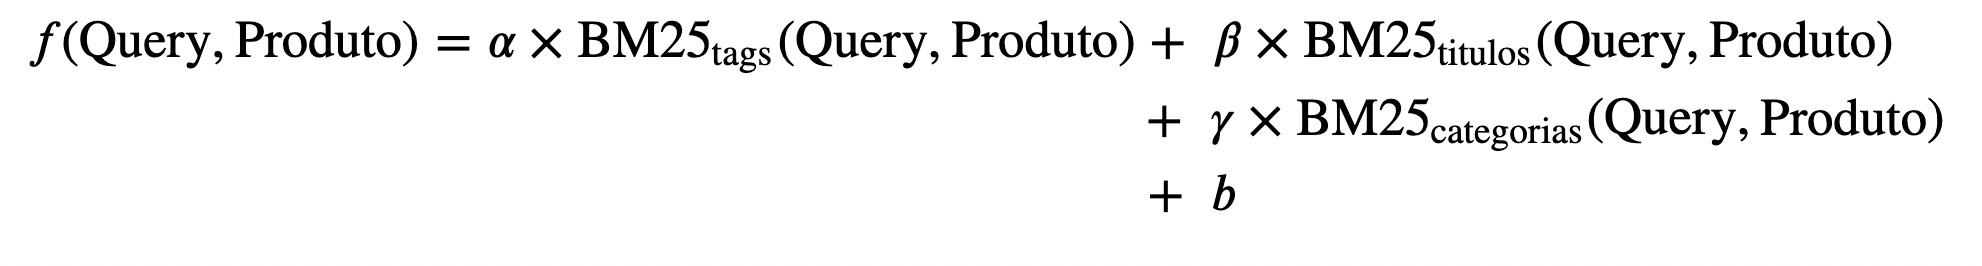


***
***
# Sumário

* # 1. [Análise exploratória e pré-preocessamento](#analise_expl)
    * ## 1.1. [Entendendo os dados](#analise_expl)
    * ## 1.2. [Analise das features textuais](#analise_feat)
    * ## 1.3. [Distribuição do número de interações](#distribuicao)
        * ### 1.3.1 [Distribuição do número de vendas](#dist_vendas)
        * ### 1.3.1 [Distribuição do número adicições no carrinho](#dist_carrinho)
        * ### 1.3.1 [Distribuição do número de cliques](#dist_cliques)
    * ## 1.4. [Pré-preocessamento: limpar e preparar dados](#limpar_preparar)
        * ## 1.4.1. [Tokenizador alternativo: BPE](#tk_alternativo)
    * ## 1.5. [Analise da frequencia](#analise_freq)

<br>


* # 2. [Construção do Índice](#construcao_ind)
    * ## 2.1 [Criando os dicionarios de índices](#criando_dict)
    * ## 2.2 [Plot de eficiência](#plot_eficiencia)
<br>


* # 3. [Retrieving e Ranking](#retrieving_ranking)

    * ## 3.1. [Organizar dataset](#org_data)
    * ## 3.2. [Score BM25](#BM25)
    * ## 3.3. [Retrieving e Ranking](#retr_rank)



<br>


* # 4. [Avaliação dos resultados](#analise_result)

    * ## 4.1. [Avaliação Qualitativa](#qualitativa)
    * ## 4.2. [Avaliação Quantitativa](#quantitativa)
        * ## 4.2.1. [Precisão e Recall](#precisao_recall)
        * ## 4.2.2. [Normalized Discounted Cumulative Gain ](#'Normalized_Discounted_Cumulative_Gain')
    
   
* # 5. [Melhorias](#melhorias)




***
***

In [2]:
#importar bibliotecas

import numpy as np
import matplotlib.pyplot as plt
#frequency cloud plot
from wordcloud import WordCloud

import seaborn as sns
import pandas as pd

plt.style.use('ggplot')

#processamento de linguagem natural
#tokenizacao, lemmatizacao em portugues

import spacy
#chamar modelo em portugues
nlp = spacy.load("pt_core_news_sm")

import re
import string
import nltk
#regular expressions biblioteca para detectar padroes em texto


<a id='analise_expl'></a>
#  1. Análise exploratória

Nesse estagio, vou me familiarizar com os dados para criar intuição sobre o problema e assim, ser capaz de começar a formular hipóteses testáveis.

## Carregando dados

In [3]:
pd.set_option('display.max_colwidth', None)

df_pairs = pd.read_csv("../dados/pairs.csv")#, delimiter=";")
df_products = pd.read_csv("../dados/products.csv")#, delimiter=";")

# 1.1. Entendendo os dados
Vamos olhar para as caracteristicas basicas do banco de dados
* Dataframe shape
* head and tail
* dtypes

Vamos começar vendo o que tem dentro de cada dataframe

In [4]:
# features da relação entre o par query e produto
print(df_pairs.info())
print(df_pairs.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89832 entries, 0 to 89831
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   pair_id            89832 non-null  int64 
 1   product_id         89832 non-null  int64 
 2   query              89832 non-null  object
 3   search_position    89832 non-null  int64 
 4   print_count_query  89832 non-null  int64 
 5   view_count_query   89832 non-null  int64 
 6   cart_count_query   89832 non-null  int64 
 7   order_count_query  89832 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 5.5+ MB
None
(89832, 8)


In [5]:
df_pairs.head()

,pair_id,product_id,query,search_position,print_count_query,view_count_query,cart_count_query,order_count_query
0,8589934593,14817,Convite Padrinhos Batismo,319,2374,18,1,0
1,8589934636,14884,Decoracao De Casamento,254,388,1,0,0
2,8589934836,8589934668,Toalha De Lavabo,233,219,2,0,0
3,8589934727,17179884005,Calendario 2023 Editavel,40,4871,2,0,0
4,8589934934,25769803777,Ecobag,286,166,3,0,0


Coluna com texto:
* query

In [6]:
print(df_products.info())
print(df_products.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76770 entries, 0 to 76769
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           76770 non-null  int64  
 1   title                76770 non-null  object 
 2   tags                 76770 non-null  object 
 3   creation_date        76770 non-null  object 
 4   price                76770 non-null  float64
 5   weight               76719 non-null  float64
 6   express_delivery     76770 non-null  int64  
 7   category             76762 non-null  object 
 8   minimum_quantity     76770 non-null  int64  
 9   print_count_product  76770 non-null  int64  
 10  view_count_product   76770 non-null  int64  
 11  cart_count_product   76770 non-null  int64  
 12  order_count_product  76770 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 7.6+ MB
None
(76770, 13)


In [7]:
#features de produtos
df_products.head()

,product_id,title,tags,creation_date,price,weight,express_delivery,category,minimum_quantity,print_count_product,view_count_product,cart_count_product,order_count_product
0,101,Jogo Banheiro de Crochê de 3 Peças,"['#jogobanheiro #croche #tapetes', 'decoração', 'nas cores chumbo e rosa bebê']",2022-09-25 13:43:36,110.0,1.0,1,Técnicas de Artesanato,1,11,0,0,0
1,106,Guardanapos de Tecido - 100 unidades,"['guardanapos de tecido', 'guradanapo', 'festa', 'evento', '15 anos', 'casamento', 'aniversário']",2014-12-26 18:47:48,269.5,0.0,0,Casa,1,62,6,0,0
2,47,Toalha Papai Noel,"['natal', 'toalha de natal', 'toalha de mesa', 'papai noel', 'feito a mão', 'crochê', 'crochet']",2013-11-06 20:43:27,291.1,0.0,0,Casa,1,423,4,0,0
3,8589941942,Caixa para 1 bis feliz natal cliente como você sempre quero,"['lembrança', 'personalizados', 'festa', 'caixas', 'caixinhas', 'rose gold', 'folhas', 'folhagem', 'verde', 'branco', 'verde e branco', 'minnie rosa', 'minnie', 'rosa', 'jardim', 'jardim encantado', 'fada morena', 'fadinha', 'pj', 'pjmask', 'natal', 'ano novo', 'feliz natal', 'brindes corporativo', 'card', 'bis', 'cartão de natal']",2021-11-22 15:02:30,45.0,0.0,0,Lembrancinhas,30,2746,93,6,2
4,17179869192,Árvore de Natal decorada em MDF,"['#madajoartesanato', '#decoraçaodenatal', '#enfeitedenatal', '#arvoredenataldecoradaemmdf']",2020-12-18 18:52:35,100.0,0.0,0,Decoração,1,1010,4,0,0


colunas de texto
* title
* tags 
* category

## Remover Null values
Vamos examinar se temos algum valor faltante nos dataframes. Dos outputs abaixo, parece que apenas as colunas **weight** e **category** do dataframe **df_products** tem valores faltantes

In [9]:
print("---- df_pairs ----")
for col in df_pairs.columns:
    print(col, df_pairs[col].isnull().sum())
print("\n")


print("---- df_products ----")
for col in df_products.columns:
    print(col, df_products[col].isnull().sum())
print("\n")

---- df_pairs ----
pair_id 0
product_id 0
query 0
search_position 0
print_count_query 0
view_count_query 0
cart_count_query 0
order_count_query 0


---- df_products ----
product_id 0
title 0
tags 0
creation_date 0
price 0
weight 51
express_delivery 0
category 8
minimum_quantity 0
print_count_product 0
view_count_product 0
cart_count_product 0
order_count_product 0




In [10]:
#removendo linhas com valores faltantes
df_products.dropna(inplace=True)
#arrumar indices depois de remover linhas nan
df_products.reset_index(inplace=True)

print("---- df_products ----")
for col in df_products.columns:
    print(col, df_products[col].isnull().sum())
print("\n")

df_products.info()
#removemos 59 linhas

---- df_products ----
index 0
product_id 0
title 0
tags 0
creation_date 0
price 0
weight 0
express_delivery 0
category 0
minimum_quantity 0
print_count_product 0
view_count_product 0
cart_count_product 0
order_count_product 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76711 entries, 0 to 76710
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                76711 non-null  int64  
 1   product_id           76711 non-null  int64  
 2   title                76711 non-null  object 
 3   tags                 76711 non-null  object 
 4   creation_date        76711 non-null  object 
 5   price                76711 non-null  float64
 6   weight               76711 non-null  float64
 7   express_delivery     76711 non-null  int64  
 8   category             76711 non-null  object 
 9   minimum_quantity     76711 non-null  int64  
 10  print_count_product  76711 non-null  int64  
 11  view_cou

In [11]:
df_products['title'][3519]

'Tubolata 7x5 Personalizada Safari'

<a id='analise_feat'></a>

# 1.2 Analise das features
Vamos olhar as features do produto mais clicado por query.

Essa analise inicial sera feita manualmente com um numero baixo de queries (20). Queremos detectar a presença de algum tipo de padrao. Aqui, queremos entender mais sobre o problema, respondendo as seguintes perguntas:
* 1. Quais features textuais parecem mais relevantes para o match (title, tags e category)?
* 2. Quais estruturas textuais importam para o match produto query? 
    
    
Vamos analisar as colunas

* title
* tags
* category
* query


In [940]:
df_all = df_pairs.merge(df_products, on='product_id')


#removendo 16611 linhas com valores nan
df_all.dropna(inplace=True)
#arrumar indices depois de remover linhas nan
df_all.reset_index(inplace=True)
df_all.sort_values(by=['search_position'], ascending=True, inplace=True)
df_all_ = df_all[['query', 'title', 'category', 'search_position', 'print_count_query', 'view_count_query', 'cart_count_query','order_count_query']]
df_all_.head(30)

,query,title,category,search_position,print_count_query,view_count_query,cart_count_query,order_count_query
40781,bolsa de croche,caixa de remedio p - agradecimento ao cliente,papel e cia,1,37430,1017,5,1
86461,presente para namorado,100 und panfleto mimo (cliente envia a logo),papel e cia,1,13275,272,4,1
22581,caixa para padrinhos,lapis personalizado lembranca de maternidade,bebe,1,41156,2826,63,11
8768,lembrancinha para formatura abc,kit com 200 lembrancinhas de casamento,casamento,1,11257,224,16,3
57163,lembrancinhas de casamento,topo de bolo casamento,aniversario e festas,1,74682,2856,123,23
30750,lembrancinhas de natal para amigos,sacolinha em tecido - natal,aniversario e festas,1,2137,67,0,0
41706,camisa do brasil,almofada formatura abc,aniversario e festas,1,3048,143,17,8
48311,brindes de natal para clientes,sousplat croche rosa bebe com branco,decoracao,1,5020,175,3,0
25101,brasileiro,semente magica personalizada,lembrancinhas,1,33792,51,2,0
76827,taca natal,kit bolsa bebe maternidade personalizada,bebe,1,11576,141,2,0


* os produtos mais recomendados da tabela de pares nao parecem ter muita relacao com as queries correspondentes. Ex:
    * query "bolsa de croche",	top 1 produto "caixa de remedio p - agradecimento ao cliente"
    * query "brindes de natal para clientes",	produto "sousplat croche rosa bebe com branco"
    * query "miolo de agenda 2023", produto "bolo fake praia"
    * query "lembrancinha para formatura abc", top 1 produto "kit com 200 lembrancinhas de casamento"

<a id='distribuicao'></a>
# 1.3 Distribuicao do numero de interacoes
<a id='dist_vendas'></a>

## 1.3.1 Distribuicao do numero de vendas

In [944]:
print(df_products.shape[0])
df_products.drop_duplicates(subset=['product_id'],inplace=True)
print(df_products.shape[0])

76711
76711


Nao ha produtos duplicados na tabela de produtos

O produto com o maior numero de vendas teve  143  vendas


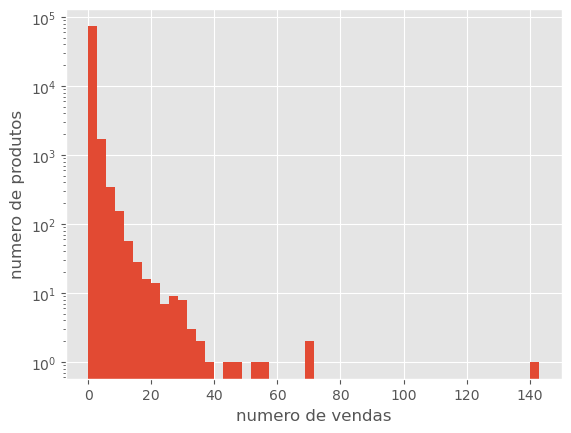

In [945]:
#distribuicao do numero total de compras a partir da aparição dos produtos
#nos resultados da busca para a consulta query

ax = df_products['order_count_product'].plot(kind='hist', bins=50, log=True)
ax.set_xlabel("numero de vendas")
ax.set_ylabel("numero de produtos")


print("O produto com o maior numero de vendas teve ",df_products['order_count_product'].max(), " vendas")

In [949]:
n_vendas = 100

print("Numero de produtos com mais de", n_vendas, "vendas é:",
      df_products[df_products['order_count_product'] >= n_vendas_par].count()['product_id'], ' produtos')

Numero de produtos com mais de 100 vendas é: 120  produtos


<a id='dist_carrinho'></a>

## 1.3.2. Distribuicao do numero adicições no carrinho

O produto que foi mais adicionado ao carrinho foi adicionado  446  vezes 

O produto que foi mais adicionado ao carrinho é 73782    copo twister 300ml personalizado c/ tampa e canudo *magal*
Name: title, dtype: object 

O produto que foi mais vendido é 73782    copo twister 300ml personalizado c/ tampa e canudo *magal*
Name: title, dtype: object 



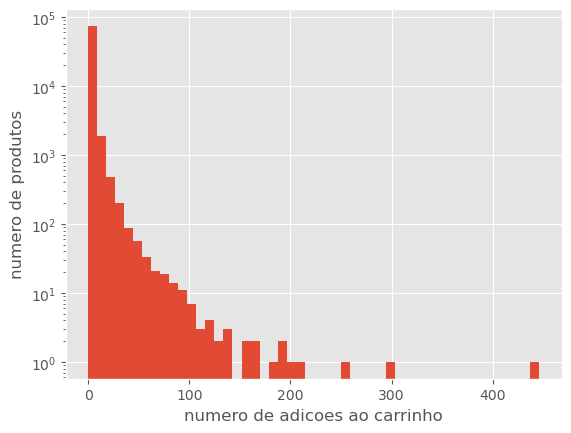

In [959]:
#distribuicao do numero total de compras a partir da aparição dos produtos
#nos resultados da busca para a consulta query

ax = df_products['cart_count_product'].plot(kind='hist', bins=50, log=True)
ax.set_xlabel("numero de adicoes ao carrinho")
ax.set_ylabel("numero de produtos")


print("O produto que foi mais adicionado ao carrinho foi adicionado ",df_products['cart_count_product'].max(), " vezes \n")
print("O produto que foi mais adicionado ao carrinho é",\
     df_products[df_products['cart_count_product'] == df_products['cart_count_product'].max()]['title'], '\n')

print("O produto que foi mais vendido é",\
     df_products[df_products['order_count_product'] == df_products['order_count_product'].max()]['title'], '\n' )


<a id='dist_cliques'></a>
## 1.3.3. Distribuição do numero cliques

O produto que recebeu mais cliques teve:  5162  cliques 

O produto que recebeu mais cliques é: 11323    caixa convite para padrinhos de casamento folhagem minimalis
Name: title, dtype: object 

O produto que foi mais adicionado ao carrinho é: 73782    copo twister 300ml personalizado c/ tampa e canudo *magal*
Name: title, dtype: object 

O produto que foi mais vendido é: 73782    copo twister 300ml personalizado c/ tampa e canudo *magal*
Name: title, dtype: object 



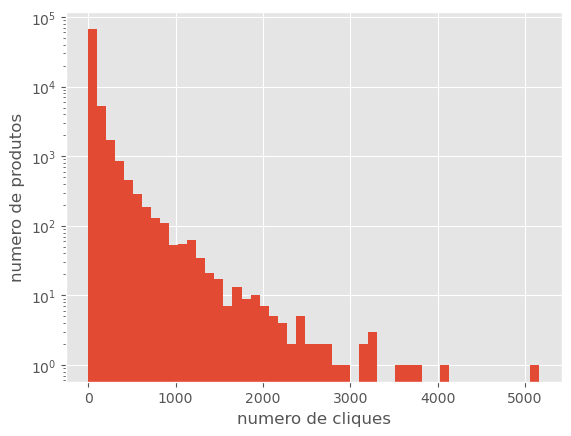

In [960]:
#distribuicao do numero total de compras a partir da aparição dos produtos
#nos resultados da busca para a consulta query

ax = df_products['view_count_product'].plot(kind='hist', bins=50, log=True)
ax.set_xlabel("numero de cliques")
ax.set_ylabel("numero de produtos")


print("O produto que recebeu mais cliques teve: ",df_products['view_count_product'].max(), " cliques \n")
print("O produto que recebeu mais cliques é:",\
     df_products[df_products['view_count_product'] == df_products['view_count_product'].max()]['title'], '\n')

print("O produto que foi mais adicionado ao carrinho é:",\
     df_products[df_products['cart_count_product'] == df_products['cart_count_product'].max()]['title'], '\n')


print("O produto que foi mais vendido é:",\
     df_products[df_products['order_count_product'] == df_products['order_count_product'].max()]['title'], '\n' )


Com essa analise, consegui entender um pouco mais do problema de negocios. Existe uma **correlacao alta** entre numero de vendas, numero de cliques e numero de adicoes ao carrinho. Especificamente, foi observado que **o produto com maior numero de vendas, adicoes ao carrinho e cliques é o mesmo**!

O que sugere que, se eu quiser usar um filtro de popularidade no meu algoritmo de search, tanto cart_count_product, quanto view_count_product, quanto order_count_product, sao aproximadamente equivalentes para medir popularidade.

<a id='limpar_preparar'></a>
#  1.4. Pré-processamento: limpar e preparar dados

Vamos preparar/limpar nossos dados para a análise exploratoria. Para decidir o que fazer nesse estagio, vamos relembrar qual é o nosso problema: queremos criar um modelo que seja capaz de, dada uma query, retornar produtos mais relevantes (baseados nas suas descricoes) e recomendar produtos diferentes.

Portanto, no estagio de limpeza de dados é interessante:
* remover captalizacao, para que o algoritmo nao diferencie, por ex.: guardanapos de Guardanapos

* Queremos remover inflexoes das palavras -> lemmetizacao

* Remover palavras que nao acrescentam signifcado ao texto (stopwords)



No fim, queremos fazer o computador entender as queries e descricoes dos produtos, para entao, poder compara-las. Assim, seguiremos as seguintes etapas:

* 1. Remover Null values
* 2. Tokenization 
* 3. Remover pontuações
* 4. Remover stopwords
* 5. Converter todos os caracteres para letras minusculas
* 7. Lemmatization/Steming 


### Lematizacao ou stemming
Stemming pode gerar dois tipos de problemas como: cortar demais e acabar com um stem que não tem sentido e perdeu muito de sua informação; ou também cortar demais e ter dois stem iguais para palavras com significados muito diferentes. A lemmatization é mais lenta, mas garante que vai gerar palavras gramaticalmente corretas e com maior precisão já que leva a classe gramatical em consideração. Portanto **para aumentar a precisao do algoritmo, farei lemmatizacao**


<a id='pontuacao'></a>


## 1.3.2 Normallizar, Remover pontuação e tokenizar

Anteriormente, vimos que as colunas que contem dados em forma de texto sao:
* em df_pair:
    * query
    
* em df_products:
    * title
    * tags 
    * category    

Com os pré-processamentos, queremos reduzir o tamanho do vocabulário e simplificar algumas formas lexicais, garantindo, assim, que o algoritmo obtenha informações relevantes e que de fato representam o nosso os produtos e as queries

## Normalizar
Vamos colocar tudo em letras minusculas e remover acentos

In [19]:
cols = df_products.select_dtypes(include=[np.object]).columns

#remover acentos
df_products[cols] = df_products[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
# todos os caracteres em letra minuscula
df_products[cols] = df_products[cols].apply(lambda x: x.str.lower())

df_products

/var/folders/b9/smrxy2957s37h5wgw3d7h9tw0000gn/T/ipykernel_47798/2774456531.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols = df_products.select_dtypes(include=[np.object]).columns


,index,product_id,title,tags,creation_date,price,weight,express_delivery,category,minimum_quantity,print_count_product,view_count_product,cart_count_product,order_count_product
0,0,101,jogo banheiro de croche de 3 pecas,"['#jogobanheiro #croche #tapetes', 'decoracao', 'nas cores chumbo e rosa bebe']",2022-09-25 13:43:36,110.0,1.0,1,tecnicas de artesanato,1,11,0,0,0
1,1,106,guardanapos de tecido - 100 unidades,"['guardanapos de tecido', 'guradanapo', 'festa', 'evento', '15 anos', 'casamento', 'aniversario']",2014-12-26 18:47:48,269.5,0.0,0,casa,1,62,6,0,0
2,2,47,toalha papai noel,"['natal', 'toalha de natal', 'toalha de mesa', 'papai noel', 'feito a mao', 'croche', 'crochet']",2013-11-06 20:43:27,291.1,0.0,0,casa,1,423,4,0,0
3,3,8589941942,caixa para 1 bis feliz natal cliente como voce sempre quero,"['lembranca', 'personalizados', 'festa', 'caixas', 'caixinhas', 'rose gold', 'folhas', 'folhagem', 'verde', 'branco', 'verde e branco', 'minnie rosa', 'minnie', 'rosa', 'jardim', 'jardim encantado', 'fada morena', 'fadinha', 'pj', 'pjmask', 'natal', 'ano novo', 'feliz natal', 'brindes corporativo', 'card', 'bis', 'cartao de natal']",2021-11-22 15:02:30,45.0,0.0,0,lembrancinhas,30,2746,93,6,2
4,4,17179869192,arvore de natal decorada em mdf,"['#madajoartesanato', '#decoracaodenatal', '#enfeitedenatal', '#arvoredenataldecoradaemmdf']",2020-12-18 18:52:35,100.0,0.0,0,decoracao,1,1010,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76706,76765,12277,sacolinha para lembrancinhas,"['sacola para lembrancinhas', 'lembrancinhas', 'sacola', 'sacolinhas', 'sacolinha para lembrancinha']",2012-01-29 02:56:46,39.0,100.0,0,bolsas e carteiras,10,117,3,0,0
76707,76766,17945,kit pulseira e gravatas para padrinhos verde tiffany,"['manual para padrinhos', 'lembranca madrinhas', 'madrinhas', 'casamento', 'manual casamento', 'madrinha', 'mimos para madrinhas', 'mymos com amor da edith', 'mymos com amor', 'pulseira para madrinha', 'casamento 2018', 'casamento 2019', 'pulseiras de perolas']",2020-01-11 18:13:16,192.8,20.0,0,casamento,4,2130,53,1,0
76708,76767,8589938478,vestido de noiva princesa novo,"['vestido de noiva', 'noiva', 'casamento', 'noivas rj', 'vestido civil', 'noivinha', 'vestido branco noiva', 'vestido branco', 'vestido princesa', 'voucasar', 'noivado', 'noivasrio', 'vestido de noiva barato', 'vestido de festa']",2020-07-04 18:37:05,490.0,0.0,1,roupas,1,3840,72,0,0
76709,76768,17179881527,papai noel amigurumi,"['presente', 'brinquedo', 'artesanato', 'artesanato croche', 'infantil', 'decoracao infantil', 'pelucia', 'crianca', 'decoracao bebe', 'boneco', 'papai noel amigurumi', 'papai noel', 'noel', 'papai noel croche', 'natal', 'decoracao natal']",2018-10-21 14:29:26,165.0,150.0,1,tecnicas de artesanato,1,2077,19,1,0


In [20]:
cols = df_pairs.select_dtypes(include=[np.object]).columns
#remover acentos
df_pairs[cols] = df_pairs[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
# todos os caracteres em letra minuscula
df_pairs[cols] = df_pairs[cols].apply(lambda x: x.str.lower())
df_pairs

/var/folders/b9/smrxy2957s37h5wgw3d7h9tw0000gn/T/ipykernel_47798/2086999200.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols = df_pairs.select_dtypes(include=[np.object]).columns


,pair_id,product_id,query,search_position,print_count_query,view_count_query,cart_count_query,order_count_query
0,8589934593,14817,convite padrinhos batismo,319,2374,18,1,0
1,8589934636,14884,decoracao de casamento,254,388,1,0,0
2,8589934836,8589934668,toalha de lavabo,233,219,2,0,0
3,8589934727,17179884005,calendario 2023 editavel,40,4871,2,0,0
4,8589934934,25769803777,ecobag,286,166,3,0,0
...,...,...,...,...,...,...,...,...
89827,1529008357415,9477,lembrancinha safari,58,6149,138,3,0
89828,1529008357501,17179878562,convite transparente em acetato impressao colorida,99,71,0,0,0
89829,1529008357505,17179878565,lembrancinha chaveiro,77,706,5,0,0
89830,1529008357518,17179878580,bolo do brasil,264,6,0,0,0


In [21]:
#criar uma lista com pontuações
punctuations = string.punctuation 
print(punctuations)

# criar uma lista de stop words em portugues
nltk.download('stopwords')

# para escolher as stopwords do português adicionamos a opçaõ de língua "portuguese" stop_words.words('portuguese')

stop_words = nltk.corpus.stopwords.words('portuguese')
stop_words

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabriela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

<a id='tokenization'></a>

# 1.3. Tokenization

Tokenizacao é uma etapa crucial de processamento de linguagem natural. Aqui, reduzimos os textos em *unidades lexicais* de forma que a maquina consiga mapear com sucesso, palavras de sentidos similares ao mesmo indice.

## Word Tokenization

Vamos quebrar os textos bruto em em tokens de palavras, remover stopwords, pontuacao e usar a lemmatizacao para tentar remover inflexoes


In [22]:
#testando tokenizador


from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('rslp')

stemmer = nltk.stem.RSLPStemmer()
#[stemmer.stem(palavra) for palavra in df_palavras['Original']]



#spacy token para remocao de pontuacoes e lematizacao em pt
text = '##eu como e durmo na minha cama. nas cores \ |\|meus pais ##gostam de dormir nas 5 camas azuis e rosas e rosa deles. tenho lembranca, lembrancinha e mais lembrancinhas #&'

text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)

#replace extra spaces with single space
text = re.sub(' +',' ',text)

#remover espacos vazios no comeco e final da string
text = text.strip()
print(text)
tokens_spacy = nlp(text)

#nltk token para remocao de stopwords
tokens_nltk = word_tokenize(text)

tokens = []
for i, word in enumerate(tokens_nltk):
    if word not in stop_words:
        #lemmatizar tudo o que nao é stopword
        word_new = tokens_spacy[i].lemma_.lower().strip() 
        tokens.append(word_new)  
        
tokens

eu como e durmo na minha cama nas cores meus pais gostam de dormir nas 5 camas azuis e rosas e rosa deles tenho lembranca lembrancinha e mais lembrancinhas


[nltk_data] Downloading package punkt to /Users/gabriela/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /Users/gabriela/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


['durmo',
 'cama',
 'cor',
 'pai',
 'gostar',
 'dormir',
 '5',
 'cama',
 'azul',
 'rosa',
 'roso',
 'lembranca',
 'lembrancinhar',
 'lembrancinha']

## Remover colunas que nao serao utilizadas no algoritmo

In [24]:
df_products.drop(['index','price','weight', 'express_delivery','price',
       'minimum_quantity', 'express_delivery'], axis=1,inplace=True)

In [25]:
def word_tokenizer_lemma(sentence):
    
    #remove todos os caracteres especiais
    sentence = re.sub(r"[^a-zA-Z0-9]+", ' ', sentence)
    
    #substituir espacos estras por um unico espaco 
    sentence = re.sub(' +',' ',sentence)

    #remover espacos vazios no comeco e final da string
    sentence = sentence.strip()
    
    #spacy: token para a lemmatizacao
    tokens_spacy = nlp(sentence)

    #nltk: token para remocao de stopwords
    tokens_nltk = word_tokenize(sentence)

    
    # lemmatizar, remover stopwords
    tokens = []
    for i, word in enumerate(tokens_nltk):
        #remover stopwords
        if word not in stop_words:
            #lemmatizar
            word_new = tokens_spacy[i].lemma_.lower()
            
            tokens.append(word_new) 
                               
    return tokens


In [26]:
df2_products = df_products.copy()
df2_pairs = df_pairs.copy()

print ('Cleaning and Tokenizing...\n----------------------------- \n----------------------------- \n')

cols = ['title', 'tags', 'category']

print("--- Products dataframe ---")
for i in cols:
    print('Processing column:', i)
    %time df2_products[i+'_tokenized'] = df2_products[i].map(lambda x: word_tokenizer_lemma(x))  


print("\n\n--- Pairs dataframe ---")
%time df2_pairs['query_tokenized'] = df2_pairs['query'].map(lambda x: word_tokenizer_lemma(x)) 

print("\n\nDone!")



df2_products.to_csv('../dados/df_products_token_lemma_list.csv')  
df2_pairs.to_csv('../dados/df_pairs_token_lemma_list.csv')

Cleaning and Tokenizing...
----------------------------- 
----------------------------- 

--- Products dataframe ---
Processing column: title
CPU times: user 3min 46s, sys: 617 ms, total: 3min 46s
Wall time: 3min 47s
Processing column: tags
CPU times: user 8min 59s, sys: 606 ms, total: 8min 59s
Wall time: 9min
Processing column: category
CPU times: user 3min 14s, sys: 179 ms, total: 3min 14s
Wall time: 3min 14s


--- Pairs dataframe ---
CPU times: user 3min 56s, sys: 251 ms, total: 3min 57s
Wall time: 3min 57s


Done!


In [61]:
#df2_pairs    = pd.read_csv("../dados/df_pairs_token_lemma_list.csv")#, delimiter=";")
#df2_products = pd.read_csv('../dados/df_products_token_lemma_list.csv')  

#df2_products.drop(['Unnamed: 0'], axis=1, inplace=True)
#df2_pairs.drop(['Unnamed: 0'], axis=1, inplace=True)

In [27]:
df2_products.head(5)

,product_id,title,tags,creation_date,category,print_count_product,view_count_product,cart_count_product,order_count_product,title_tokenized,tags_tokenized,category_tokenized
0,101,jogo banheiro de croche de 3 pecas,"['#jogobanheiro #croche #tapetes', 'decoracao', 'nas cores chumbo e rosa bebe']",2022-09-25 13:43:36,tecnicas de artesanato,11,0,0,0,"[jogo, banheiro, croche, 3, peca]","[jogobanheiro, crochar, tapete, decoracao, cor, chumbo, roso, beber]","[tecnica, artesanato]"
1,106,guardanapos de tecido - 100 unidades,"['guardanapos de tecido', 'guradanapo', 'festa', 'evento', '15 anos', 'casamento', 'aniversario']",2014-12-26 18:47:48,casa,62,6,0,0,"[guardanapo, tecido, 100, unidade]","[guardanapo, tecido, guradanapo, festa, evento, 15, ano, casamento, aniversario]",[casa]
2,47,toalha papai noel,"['natal', 'toalha de natal', 'toalha de mesa', 'papai noel', 'feito a mao', 'croche', 'crochet']",2013-11-06 20:43:27,casa,423,4,0,0,"[toalha, papai, noel]","[natal, toalha, natal, toalha, mesa, papai, noel, fazer, mao, croche, crochet]",[casa]
3,8589941942,caixa para 1 bis feliz natal cliente como voce sempre quero,"['lembranca', 'personalizados', 'festa', 'caixas', 'caixinhas', 'rose gold', 'folhas', 'folhagem', 'verde', 'branco', 'verde e branco', 'minnie rosa', 'minnie', 'rosa', 'jardim', 'jardim encantado', 'fada morena', 'fadinha', 'pj', 'pjmask', 'natal', 'ano novo', 'feliz natal', 'brindes corporativo', 'card', 'bis', 'cartao de natal']",2021-11-22 15:02:30,lembrancinhas,2746,93,6,2,"[caixar, 1, bis, feliz, natal, cliente, voce, sempre, querer]","[lembranca, personalizar, festa, caixa, caixinho, rose, gold, folha, folhagem, verde, branco, verde, branco, minnie, roso, minnie, rosa, jardim, jardim, encantar, far, morena, fadinha, pj, pjmask, natal, ano, novo, feliz, natal, brinde, corporativo, card, bis, cartao, natal]",[lembrancinha]
4,17179869192,arvore de natal decorada em mdf,"['#madajoartesanato', '#decoracaodenatal', '#enfeitedenatal', '#arvoredenataldecoradaemmdf']",2020-12-18 18:52:35,decoracao,1010,4,0,0,"[arvore, natal, decorar, mdf]","[madajoartesanato, decoracaodenatal, enfeitedenatal, arvoredenataldecoradaemmdfr]",[decoracao]


In [28]:
df2_pairs.head(5)

,pair_id,product_id,query,search_position,print_count_query,view_count_query,cart_count_query,order_count_query,query_tokenized
0,8589934593,14817,convite padrinhos batismo,319,2374,18,1,0,"[convite, padrinho, batismo]"
1,8589934636,14884,decoracao de casamento,254,388,1,0,0,"[decoracao, casamento]"
2,8589934836,8589934668,toalha de lavabo,233,219,2,0,0,"[toalha, lavabo]"
3,8589934727,17179884005,calendario 2023 editavel,40,4871,2,0,0,"[calendario, 2023, editavel]"
4,8589934934,25769803777,ecobag,286,166,3,0,0,[ecobag]


## 1. BPE tokenizer
Criar tokens de sub-palavras à partir do corpo de documentos. Pra isso, ele precisa treinar sob todo o corpo para aprender a identificar os tokens mais apropriados.

BPE é um tokenizador muito utilizado. A vantagem desse tokenizador 
* palavras frequentes sao mantidas e nao segmentadas
* palavras raras sao segmentadas em tokens de subpalavra


Esse tokenizador sera especialmente util para lidar com a coluna de *tags_produtos* que contem palavras como: jogobanheiro

In [29]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

In [30]:
# criar dataframe com todos os dados textuais
df2_all = df2_pairs.merge(df2_products, on="product_id", how="inner")
df2_all.head()

,pair_id,product_id,query,search_position,print_count_query,view_count_query,cart_count_query,order_count_query,query_tokenized,title,tags,creation_date,category,print_count_product,view_count_product,cart_count_product,order_count_product,title_tokenized,tags_tokenized,category_tokenized
0,8589934593,14817,convite padrinhos batismo,319,2374,18,1,0,"[convite, padrinho, batismo]",bebe reborn menino promocao,"['bebe reborn', 'bebe reborn promocao', 'boneca bebe reborn menino', 'bebe reborn olhos abertos', 'bebe reborn barato', 'bebe reborn molde mary', 'bebe reborn de silicone']",2022-04-30 01:08:08,jogos e brinquedos,3728,466,8,3,"[beber, reborn, menino, promocao]","[beber, reborn, bebe, reborn, promocao, boneca, beber, reborn, menino, beber, reborn, olho, abrir, beber, reborn, barato, beber, reborn, molde, mary, beber, reborn, silicone]","[jogo, brinquedo]"
1,8589934636,14884,decoracao de casamento,254,388,1,0,0,"[decoracao, casamento]",quadro de incentivos patrulha canina,"['quadro de incentivos patrulha canina', 'quadro de incentivos', 'patrulha canina', 'quadro de tarefas']",2018-05-07 14:35:50,infantil,192,9,1,0,"[quadro, incentivo, patrulha, canino]","[quadro, incentivo, patrulha, canino, quadro, incentivo, patrulha, canino, quadro, tarefa]",[infantil]
2,8589934836,8589934668,toalha de lavabo,233,219,2,0,0,"[toalha, lavabo]",mini topper para docinhos personalizado tema cha revelacao,"['delicate', 'lembrancinhas', 'lembrancinhapersonalizada', 'personalizados', 'topper', 'topper de doces', 'mini topper', 'festa personalizada', 'festa em casa', 'docinhos de festa', 'doce de festa', 'revelacao', 'cha revelacao']",2020-09-16 12:02:09,lembrancinhas,878,49,4,1,"[mini, topper, docinho, personalizar, tema, cha, revelacao]","[delicate, lembrancinha, lembrancinhapersonalizada, personalizar, topper, topper, doce, mini, topper, festa, personalizar, festa, casa, docinho, festa, doce, festa, revelacao, char, revelacao]",[lembrancinha]
3,8589934727,17179884005,calendario 2023 editavel,40,4871,2,0,0,"[calendario, 2023, editavel]",chaveiro de resina personalizado,"['chaveiro', 'chaveiros', 'chaveiro de resina', 'lembrancinha de chaveiro', 'chaveiro de lembrancinha', 'epoxi', 'resina', 'resina epoxi', 'lembrancinhas', 'lembrancinha', 'chaveiro de letra', 'chaveiro de letra resina', 'letra', 'chaveiro personalizado', 'pompom', 'chaveiro com pompom', 'alfabeto', 'presente', 'tassel', 'cha de bebe', 'casamento', 'madrinha', 'padrinhos', 'noivas', 'handmade', 'personalizado', 'lembrancinha personalizada', 'enfeite', 'artesanal', 'artesanato', 'batizado', 'aniversario', 'letra de resina', 'nome de resina', 'numero', 'numero de resina']",2021-06-07 00:15:34,acessorios,1113,27,1,0,"[chaveiro, resina, personalizar]","[chaveiro, chaveiro, chaveiro, resina, lembrancinhar, chaveiro, chaveiro, lembrancinha, epoxi, resina, resino, epoxi, lembrancinha, lembrancinhar, chaveiro, letra, chaveiro, letra, resina, letra, chaveiro, personalizar, pompom, chaveiro, pompom, alfabeto, presente, tassel, cha, bebe, casamento, madrinha, padrinho, noivo, handmade, personalizar, lembrancer, personalizar, enfeite, artesanal, artesanato, batizar, aniversario, letra, resina, nome, resina, numero, numero, resina]",[acessorio]
4,8589934934,25769803777,ecobag,286,166,3,0,0,[ecobag],chaveiro safari amigurumi para lembrancinha,"['aniversario', 'safari', 'safari para menina', 'lembrancinhas', 'lembrancas de aniversario', 'lembrancas de nascimento', 'festa safari']",2022-02-27 22:47:43,aniversario e festas,9370,469,5,0,"[chaveiro, safari, amigurumer, lembrancinha]","[aniversario, safari, safari, menina, lembrancinha, lembranco, aniversario, lembranca, nascimento, festa, safari]","[aniversario, festa]"


In [31]:
# -- Atencao -- Rodar uma vez!

#tokenized_columns = ['query_tokenized','title_tokenized', 'tags_tokenized',
#       'category_tokenized']

#escrever arquivo raw que o tokenizador consiga ler e treinar
#with open('tokenizer_data/train_tokenizer_lemma_all.raw', 'w+') as fp:
    
    # olhar dataframe com itens pre tokenizados linha a linha
#    for _,linha in df2_all.iterrows():
        
        #selecionar coluna
#        for column in tokenized_columns:
            
#            lista = linha[column]

            # selecionar palavra dentro da lista
#            for element in lista:
#                fp.write(f"{element} \n")

In [32]:
# se o meu corpo de documentos nao for grande o suficiente
# terei um conjunto de silabas desconhecido [UNK]
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

tokenizer.pre_tokenizer = Whitespace()


#vocab_size é a quantidade tokens que o algoritmo vai ter no final. quanto maior
# vocab_size maiores serao os tokens
trainer500 = BpeTrainer(vocab_size=500, 
                     show_progress=True,
                     special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

#treinar tokenizador em todos os documentos
%time tokenizer.train(files=["tokenizer_data/train_tokenizer_lemma_all.raw"], trainer=trainer500)




CPU times: user 14.9 s, sys: 7.67 s, total: 22.6 s
Wall time: 4.09 s


In [33]:
#vocab_size = 500
output500 = tokenizer.encode("reborn lembrancinha de jogobanheiro guradanapo")
output500.tokens

['reborn',
 'lembrancinha',
 'de',
 'jogo',
 'ban',
 'h',
 'eiro',
 'gu',
 'ra',
 'd',
 'ana',
 'po']

In [34]:
#vocab_size é a quantidade tokens que o algoritmo vai ter no final
# se o meu corpo de documentos nao for grande o suficiente
# terei um conjunto de silabas desconhecido


tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

trainer1000 = BpeTrainer(vocab_size=1000, 
                     show_progress=True,
                     special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

%time tokenizer.train(files=["tokenizer_data/train_tokenizer_lemma_all.raw"], trainer=trainer1000)




CPU times: user 14.7 s, sys: 7.72 s, total: 22.4 s
Wall time: 4.05 s


In [35]:
#vocab_size = 1000
output1000 = tokenizer.encode("reborn lembrancinha de jogobanheiro guradanapo")
output1000.tokens

['reborn',
 'lembrancinha',
 'de',
 'jogo',
 'banheiro',
 'gu',
 'ra',
 'd',
 'ana',
 'po']

In [36]:
linha = ["reborn", "lembrancinha", "jogobanheiro"]
bpe_tokens = [tokenizer.encode(element).tokens for element in linha]
print(bpe_tokens)
# pra achatar a lista
import itertools
bpe_tokens =list(itertools.chain(*bpe_tokens))
bpe_tokens

[['reborn'], ['lembrancinha'], ['jogo', 'banheiro']]


['reborn', 'lembrancinha', 'jogo', 'banheiro']

## Aplicar tokenizador BPE no banco de dados

In [37]:
# pra achatar a lista
import itertools

In [38]:
#inicializar tokenizador
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

#vamos deixar vocab_size=1000 por conveniencia
trainer = BpeTrainer(vocab_size=1000, 
                     show_progress=True,
                     special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

%time tokenizer.train(files=["tokenizer_data/train_tokenizer_lemma_all.raw"], trainer=trainer)




def bpe_tokenizer(sentence):
    'aplica a tokenizacao bpe linha a linha no dataframe'
    
    #criar objeto token 
    bpe_tokens = [tokenizer.encode(element).tokens for element in sentence]
    bpe_tokens = list(itertools.chain(*bpe_tokens))

    return bpe_tokens




CPU times: user 14.7 s, sys: 7.73 s, total: 22.4 s
Wall time: 4.07 s


In [39]:
print ('BPE tokenizing...\n-------------------------- \n-------------------------- \n')

cols_tokenized = ['title_tokenized', 'tags_tokenized', 'category_tokenized']

print("--- Products dataframe ---")
for i in cols_tokenized:
    print('Processing column:', i)
    %time df2_products[i+'_bpe'] = df2_products[i].map(lambda x: bpe_tokenizer(x))  


print("\n\n--- Pairs dataframe ---")
%time df2_pairs['query_tokenized_bpe'] = df2_pairs['query_tokenized'].map(lambda x: bpe_tokenizer(x)) 

print("\n\nDone!")

BPE tokenizing...
-------------------------- 
-------------------------- 

--- Products dataframe ---
Processing column: title_tokenized
CPU times: user 1.72 s, sys: 17.4 ms, total: 1.74 s
Wall time: 1.74 s
Processing column: tags_tokenized
CPU times: user 13.5 s, sys: 137 ms, total: 13.6 s
Wall time: 13.7 s
Processing column: category_tokenized
CPU times: user 767 ms, sys: 9.45 ms, total: 777 ms
Wall time: 776 ms


--- Pairs dataframe ---
CPU times: user 961 ms, sys: 9.24 ms, total: 970 ms
Wall time: 970 ms


Done!


In [40]:
df2_products[['title_tokenized', 'title_tokenized_bpe','tags_tokenized', 'tags_tokenized_bpe',\
              'category_tokenized', 'category_tokenized_bpe']].head(2)

,title_tokenized,title_tokenized_bpe,tags_tokenized,tags_tokenized_bpe,category_tokenized,category_tokenized_bpe
0,"[jogo, banheiro, croche, 3, peca]","[jogo, banheiro, croche, 3, pe, ca]","[jogobanheiro, crochar, tapete, decoracao, cor, chumbo, roso, beber]","[jogo, banheiro, cro, char, tapete, decoracao, cor, chu, m, bo, roso, beber]","[tecnica, artesanato]","[te, c, n, ica, artesanato]"
1,"[guardanapo, tecido, 100, unidade]","[guardanapo, tecido, 10, 0, un, idade]","[guardanapo, tecido, guradanapo, festa, evento, 15, ano, casamento, aniversario]","[guardanapo, tecido, gu, ra, d, ana, po, festa, evento, 15, ano, casamento, aniversario]",[casa],[casa]


In [41]:
df2_pairs[['query','query_tokenized', 'query_tokenized_bpe']].head(2)

,query,query_tokenized,query_tokenized_bpe
0,convite padrinhos batismo,"[convite, padrinho, batismo]","[convite, padrinho, batismo]"
1,decoracao de casamento,"[decoracao, casamento]","[decoracao, casamento]"


Imprime a frequencia com a qual essas palavras aparecem no banco de dados

<a id='analise_freq'></a>


# 1.4 Analise da frequencia
Aqui queremos responder as seguintes perguntas:
* ### 1. Quais sao as palavras mais comuns nas queries?
* ### 2. Quais sao as palavras mais comuns nos produtos?
* ### 3. Parece existir correlacao entre palavras mais comuns nas queries e nos produtos?

In [44]:
#top 10 palavras mais frequentes nos titulos dos produtos
print("top 10 palavras mais frequentes nas queries\n", pd.Series(np.concatenate(df2_products['title_tokenized']))\
                                                    .value_counts()[:10], "\n" )

top 10 palavras mais frequentes nas queries
 natal            12043
personalizar      7800
kit               6688
lembrancinhar     6388
maternidade       4371
croche            4220
casamento         3467
porta             3453
mesa              3444
convite           3000
dtype: int64 



In [45]:
#top 10 palavras mais frequentes nos titulos dos produtos
print( "top 10 palavras mais frequentes nos titulos dos produtos\n", pd.Series(np.concatenate(df2_products['title_tokenized']))\
                                                    .value_counts()[:10], "\n"  )

print( "top 10 palavras mais frequentes nas tags dos produtos\n", pd.Series(np.concatenate(df2_products['tags_tokenized']))\
                                                    .value_counts()[:10], "\n"  )

print( "top 10 palavras mais frequentes nas categorias dos produtos\n", pd.Series(np.concatenate(df2_products['category_tokenized']))\
                                                    .value_counts()[:10] )

top 10 palavras mais frequentes nos titulos dos produtos
 natal            12043
personalizar      7800
kit               6688
lembrancinhar     6388
maternidade       4371
croche            4220
casamento         3467
porta             3453
mesa              3444
convite           3000
dtype: int64 

top 10 palavras mais frequentes nas tags dos produtos
 personalizar     89523
natal            82352
festa            70392
lembrancinhar    68619
decoracao        43589
casamento        37385
quadro           33076
convite          32758
presente         31813
infantil         30301
dtype: int64 

top 10 palavras mais frequentes nas categorias dos produtos
 lembrancinha    18704
festa           11645
aniversario     11117
decoracao       10585
beber            6105
papel            5449
cia              5289
casamento        4447
casa             3810
roupa            3401
dtype: int64


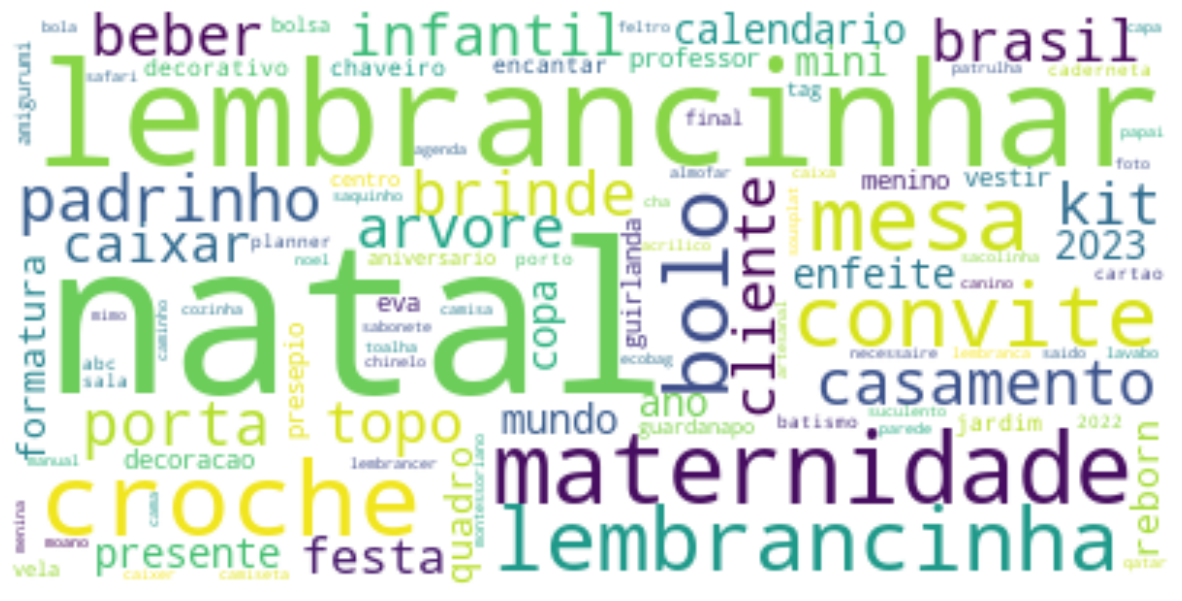

In [46]:
#queries
series = pd.Series(np.concatenate(df2_pairs['query_tokenized']))\
                                                    .value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

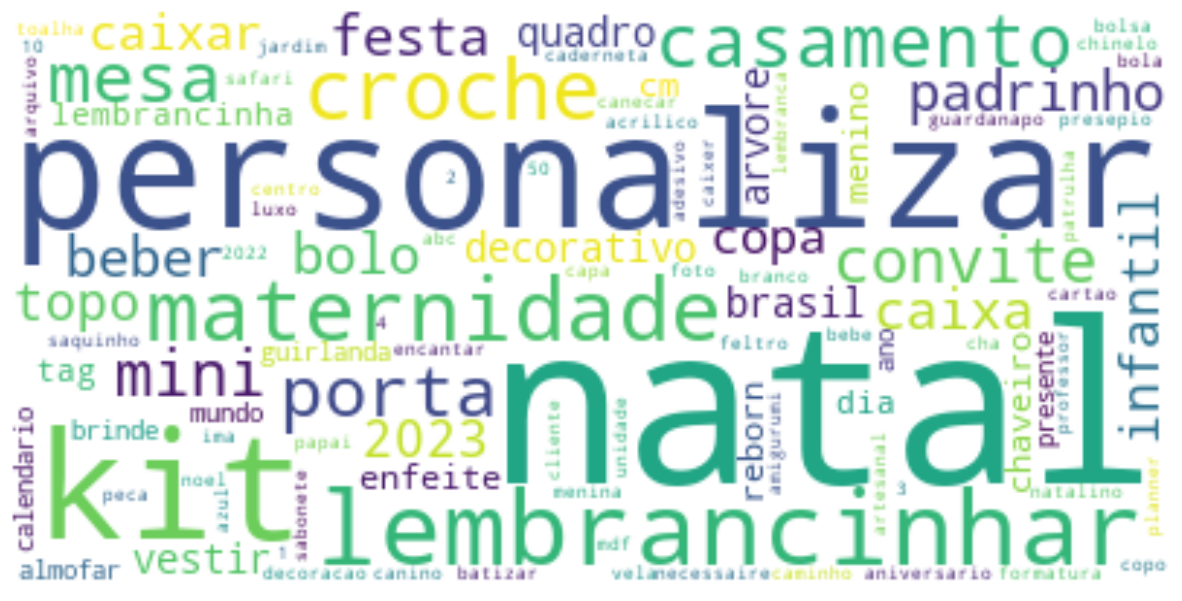

In [47]:
#tags
series = pd.Series(np.concatenate(df2_products['title_tokenized']))\
                                                    .value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<a id='construcao_ind'></a>


# 2. Construcao do indice: 
O primeiro passo na construcao de um text search engine é construir os **inverted index**. Um inverted index é uma estrutura de dados que **mapeia tokens para os documentos** em que eles aparecem

Nos ja tokenizamos, normalizamos e limpamos o copus de documentos no passo anterior. Para que possamos fazer **single word queries** (retrieval de documentos que dao match em pelo menos uma das palavras da query) e **phrase queries** (retrieval de documentos que dao match com as palavras da query na sequencia em que elas foram escritas pelo usuario), precisamos armazenar tanto o documento que contem o token quanto *onde* em cada documento o token esta. Portanto, construirei um *objeto dictionary* na seguite estrutura:


            InverseIndex_dict = {'token1': [[doc_i_index, posicao_no_doc1],[doc_j_index, posicao_no_doc3], ...], 'token2': [[doc_k_index, posicao_no_doc_k],[doc_index_l, posicao_no_doc_], ...] ..., 'tokenN': [[doc_k_index, posicao_no_doc_k], ...]} 
            
**Esse passo demora muito para ser computado, mas só precisa ser computado uma vez!**

Para evitar varios *for loops* explicitos, vou criar funcoes de recuperacao de indices que por sua vez serao aplicadas à funcao **.apply()** da biblioteca pandas que fara o loop por palavras e documentos de forma mais eficiente.

In [48]:
#
#funcoes para criar dicionario de indice invertido! 
#

def funct_doc(doc, word, docs, column_name):
    """
    funcao de recuperacao de:
    idx       = indice de documento no corpo de documentos
    positions = posicao do token no doumento
    
    """
    if word in doc:
        idx = docs[docs[column_name].apply(lambda x: x==doc)].index[0]

        positions = list(np.where(np.array(doc) == word)[0])
                        
        return [idx, positions]
    
    return [np.nan, np.nan]
    
    

def funct_words(word, docs, column_name):
    """
    funcao que sera aplicada ao dataframe de vocabulario: unique_words
    
    Aplica funct_doc no corpo de documentos e armazena outputs 
    [idx, position] num dataframe auxiliar (df_aux)
    
    Remove np.nan do dataframe auxiliar e retorna uma lista de listas para cada token:
    [[doc_i_index, posicao_no_doc1],[doc_j_index, posicao_no_docj], ...]
    
    """
    
    df_aux = pd.DataFrame()
    
    df_aux[column_name] = docs[column_name].apply(lambda doc: funct_doc(doc, word, docs, column_name))
    
    list_por_token = list(df_aux[df_aux[column_name].apply(lambda x: x!=[np.nan, np.nan])][column_name]) 
    
    return list_por_token


In [50]:
#fazer teste

column_name = 'tags_tokenized_bpe'

docsteste = df2_products[:1000]

#cria lista de vocabulario das queries
all_docs_words = pd.DataFrame(np.concatenate(docsteste[column_name]), columns=['words'])
unique_words = all_docs_words.value_counts().reset_index()

unique_words.rename(columns={0: 'frequency'}, inplace=True)

# aplicamos a funcao funct_words em cada token na serie unique_tokens['words']
# armazenamos os inverse indexes de cada token numa nova coluna unique_words['inv_idx']
%time unique_words['inv_idx'] = unique_words['words'].apply(lambda word: funct_words(word, docsteste, column_name) )


# pega o df de tokens e inv_idx e transforma em dicionario
dict_inv_idx_tags = dict(zip(unique_words.words, unique_words.inv_idx))

CPU times: user 8.91 s, sys: 45.6 ms, total: 8.96 s
Wall time: 9.04 s


In [51]:
#teste
print(dict_inv_idx_tags['natal'][0])
print(docsteste[column_name][2])
# passou no teste!

[2, [0, 2]]
['natal', 'toalha', 'natal', 'toalha', 'mesa', 'papai', 'noel', 'fazer', 'mao', 'croche', 'croche', 't']


<a id='criando_dict'></a>

## 2.1. Criando os dicionarios de índices
Por limitacao de tempo, vou contruir indices apenaspara os tokens da tokenizacao por palavras - tokenizacao BPE aumenta a quantidade de tokens, leva a um tempo ainda maior para construir indices

In [54]:
column_name = 'tags_tokenized'

docsteste = df2_products

#cria lista de vocabulario das queries
all_tags_words = pd.DataFrame(np.concatenate(docsteste[column_name]), columns=['words'])
unique_words = all_tags_words.value_counts().reset_index()

unique_words.rename(columns={0: 'frequency'}, inplace=True)

# aplicamos a funcao funct_words em cada token na serie unique_tokens['words']
# armazenamos os inverse indexes de cada token numa nova coluna unique_words['inv_idx']
%time unique_words['inv_idx'] = unique_words['words'].apply(lambda word: funct_words(word, docsteste, column_name) )


# pega o df de tokens e inv_idx e transforma em dicionario
inv_idx_tags = dict(zip(unique_words.words, unique_words.inv_idx))

CPU times: user 5h 9min 46s, sys: 1min 3s, total: 5h 10min 50s
Wall time: 5h 10min 57s


In [55]:
column_name = 'title_tokenized'

docsteste = df2_products

#cria lista de vocabulario das queries
all_title_words = pd.DataFrame(np.concatenate(docsteste[column_name]), columns=['words'])
unique_words = all_title_words.value_counts().reset_index()

unique_words.rename(columns={0: 'frequency'}, inplace=True)

# aplicamos a funcao funct_words em cada token na serie unique_tokens['words']
# armazenamos os inverse indexes de cada token numa nova coluna unique_words['inv_idx']
%time unique_words['inv_idx'] = unique_words['words'].apply(lambda word: funct_words(word, docsteste, column_name) )


# pega o df de tokens e inv_idx e transforma em dicionario
inv_idx_title = dict(zip(unique_words.words, unique_words.inv_idx))

CPU times: user 1h 24min 32s, sys: 22 s, total: 1h 24min 54s
Wall time: 1h 24min 57s


In [56]:
column_name = 'category_tokenized'

docsteste = df2_products

#cria lista de vocabulario das queries
all_docs_words = pd.DataFrame(np.concatenate(docsteste[column_name]), columns=['words'])
unique_words = all_docs_words.value_counts().reset_index()

unique_words.rename(columns={0: 'frequency'}, inplace=True)

# aplicamos a funcao funct_words em cada token na serie unique_tokens['words']
# armazenamos os inverse indexes de cada token numa nova coluna unique_words['inv_idx']
%time unique_words['inv_idx'] = unique_words['words'].apply(lambda word: funct_words(word, docsteste, column_name) )


# pega o df de tokens e inv_idx e transforma em dicionario
inv_idx_category = dict(zip(unique_words.words, unique_words.inv_idx))

CPU times: user 20min 21s, sys: 4.53 s, total: 20min 26s
Wall time: 20min 27s


<a id='plot_eficiencia'></a>

# 2.2. Plot de eficiência

Text(0, 0.5, 'doc corpus size')

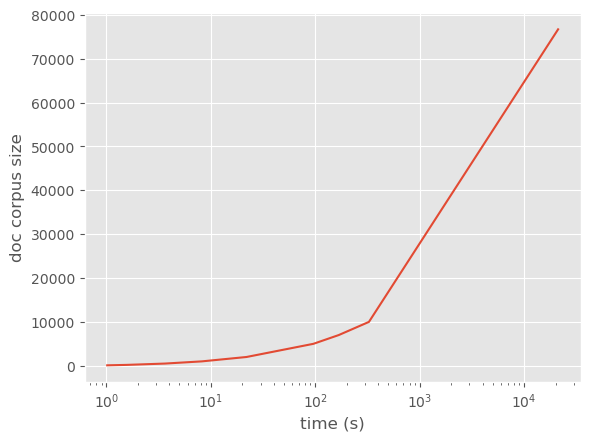

In [931]:
#como tempo do InverseIndex escala com o numero de documentos

time = np.array([ 1.02, 1.57, 3.64, 8.22, 22, 96, 168, 327, 21170])
size = np.array([100, 200, 500, 1000, 2000, 5000, 7000, 10000, 76711])
plt.plot(time,size)
plt.xlabel('time (s)')
plt.xscale('log')
plt.ylabel('doc corpus size')

## Salvar dicionarios

In [59]:
#import pickle

#salvar dicionarios
with open('InvertedIndex_tags.pkl', 'wb') as f:
    pickle.dump(inv_idx_tags, f)
    
with open('InvertedIndex_title.pkl', 'wb') as f:
    pickle.dump(inv_idx_title, f)
    
with open('InvertedIndex_category.pkl', 'wb') as f:
    pickle.dump(inv_idx_category, f)

<a id='retrieving_ranking'></a>

# 3. Retrieving e Ranking
Text retrieval é uma tarefa em que o sistema responderá à query do usuario com documentos *relevantes*. A colecao de documentos relevantes é uma funçao da query $R(q)$ e é dependente do usuario. Portanto, vou encontar $R'(q)$, uma estimativa dos documentos relevantes - para encontar essa funcao, farei ranking onde a funcao $f(q,d)\in  \mathbb{R}$ é uma funcao de medida de relevancia. Existem varios algoritmos diferentes para computar $f(q,d)$.

Nesse notebook adotei um modelo baseado em "bag of words" (BM25) para computar a relevancia do texto, de forma que o score das palavras é determinado pela frequencia com a qual elas aparecem no corpo de documentos. Assim, dando match com um termo raro na colecao de palavras vai contribuir mais para o score total do que dar match com um termo comum.


Aqui vou desenvolver meu algortimo de search engine. Vou partir de um algoritmo simples e analisar os 
* o retriving feito pelo match palavra-palavra das palavras da query com as palavras das features de produtos; 

* o ranking feito com um modelo de bag-of-words (BM25) para calcular o score individual das features de produto e uma funcao linear para combinar esses scores individuais no score de relevancia final

***
<a id='org_data'></a>

## 3.1. Organizar dataset

In [291]:
#criar um data frame unico para ser usado na regressao
data = df2_pairs.merge(df2_products, on='product_id', how='left')

data['target'] = data['view_count_query']/data['print_count_query']

#removendo 16611 linhas com valores nan
data.dropna(inplace=True)
#arrumar indices depois de remover linhas nan
data.reset_index(inplace=True)

#manter apenas as colunas de interesse
data = data[['index', 'pair_id', 'product_id', 'query_tokenized', 'query_tokenized_bpe', 
       'title_tokenized', 'title_tokenized_bpe', 'tags_tokenized', 'tags_tokenized_bpe', 'category_tokenized',
       'category_tokenized_bpe', 'target']]


#remover listas vazias
data.drop(data[data['tags_tokenized'].str.len() == 0].index.values, inplace=True)
data.reset_index(inplace=True)

<a id='BM25'></a>

## 3.2. Score BM25 
O score de relevancia se torna do par da query produtotorna-se:

# $ \text{score} = \text{IDF}\,\times\, \frac{(k+1)\,\times\, \text{TF}}{\text{TF}+k \,\times\, (1-b+b \,\times \, \text{dl_adl})} $

onde $\text{dl_adl}$ é o comprimento do documento atual dividido pelo comprimento medio de todos os documentos. $k$ e $b$ sao *hiperparametros* introduzidos ao modelo tf-idf que serve para ajustar o impacto dos itens na funcao de rankeamento. Especificamente: $'k'$ ajusta o impacto de saturacao de termo e $'b$ ajusta o tamanho do documento.

<br>

Adotarei a seguinte variacao do algoritmo BM25:

<div>
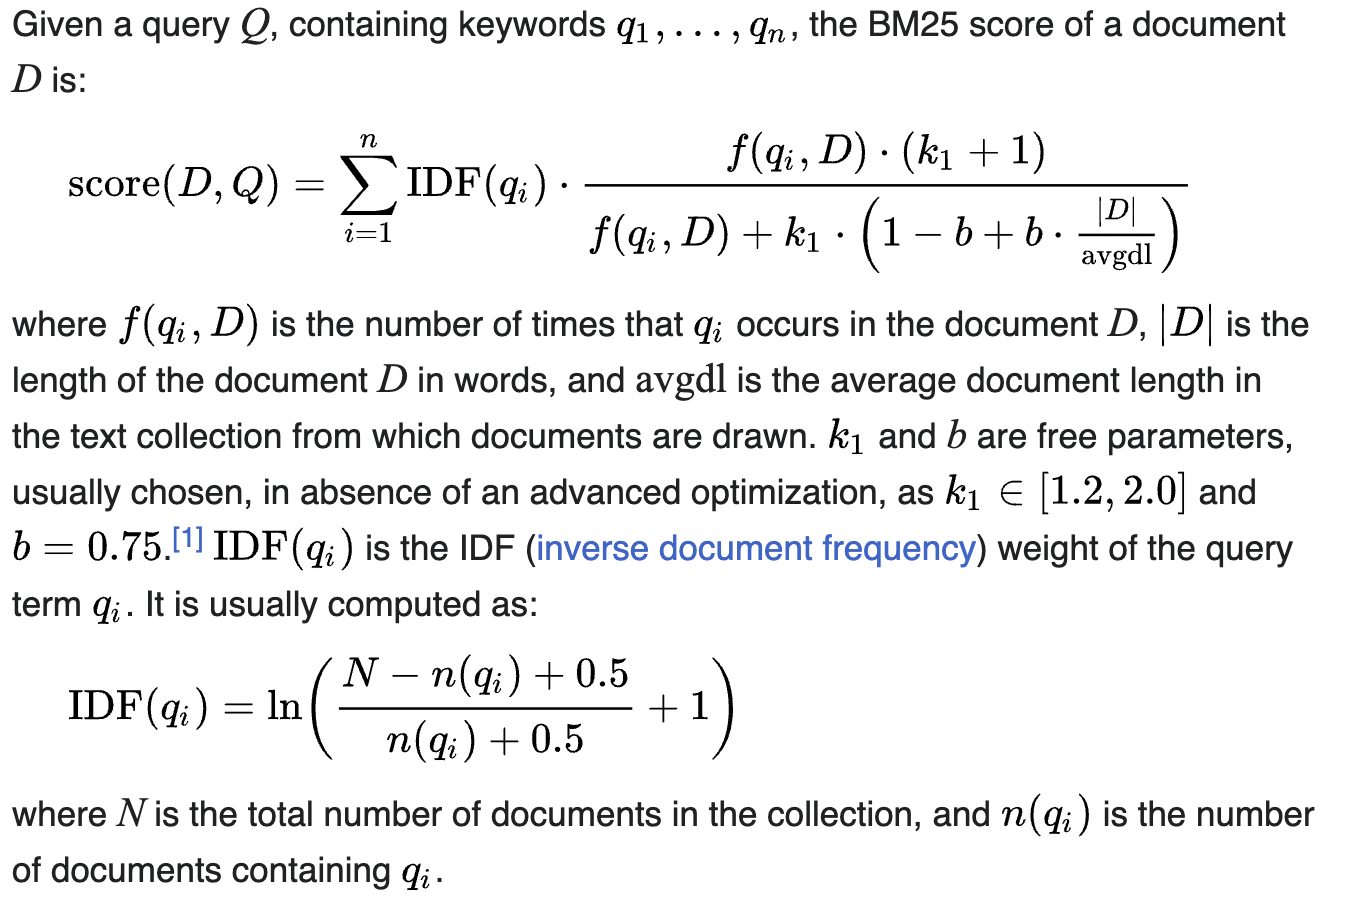
</div>


In [928]:
#posso computar antes da query!

def avgdl(docs):
    """
    computa o tamanho medio dos documentos na colecao
    
    retorna um float
    
    """
    doc_lengths = docs.apply(lambda x: len(x)) 
    
    return doc_lengths.mean()


tags_avgdl     = avgdl(df2_products['tags_tokenized'])
title_avgdl    = avgdl(df2_products['title_tokenized'])
category_avgdl = avgdl(df2_products['category_tokenized'])



def tf(word, doc):
    """
    computa o numero de vezes que um item da query em um documento
    
    retorna um float
    
    """
    return doc.count(word) / len(doc)



def weighted_tf(word, doc, docs, AVGDL, k1, b1):
    """
    computa o numero de documentos para um item da query
    
    retorna um float
    
    """
    
    a = tf(word, doc) * (k1+1)
    b = tf(word, doc) + k1 * (1. - b1 + b1 * len(doc)/AVGDL)
    
    
    return a/b




def n_contain(word, docs):
    """
    computa o numero de documentos que contem um item do vocabulario
    
    retorna um float
    
    """
    return sum(1 for doc in docs if word in doc)




def idf(word, docs):
    """
    computa o idf para um item do vocabulario
    
    retorna um float
    
    """  
    N_docs = docs.shape[0]
    
    #idf = np.log(N_docs - freq(word, docs) + 0.5) - np.log( freq(word,docs) + 0.5 )
    idf = np.log( N_docs + 1 ) - np.log( n_contain(word,docs) + 0.5 )

    return idf





def bm25_score(query, doc, docs, AVGDL, k1=1.5, b1=0.75):
    """
    computa o score de um documento, dada uma query
    
    retona float: score total por query por documento
    """ 
    
    score_value = 0
    for word in query:
        score = idf(word, docs) * weighted_tf(word, doc, docs, AVGDL, k1, b1)
        score_value += score
        
        
    return score_value

<a id='retr_rank'></a>


# 3.3 Retrieving e Ranking

Depois de criar o indice, temos que utiliza-lo. Vou construir um modelo, que procure match entre as palavras da query e as palavras das colunas textuais (que foram indexadas). E depois trazer os resultados ordenados por relevancia de acordo com o valor de score BM25.


Como tenho tres colunas de features textuais dos produtos (categoria, titulo e tags), vou o meu ranking sera um modelo linar (por simplicidade) dos scores de relevancia BM25 de cada uma das features:

![Screen%20Shot%202023-02-10%20at%204.37.59%20PM.png](attachment:Screen%20Shot%202023-02-10%20at%204.37.59%20PM.png)

                                   
                                   
onde $\alpha$, $\beta$, $\gamma$ e $b$ sao hiperparametros do modelo linear e que podem ser otimizados numa rotina de Machine Learning. Por simplicidade, defini os valores de default como $\alpha = \beta = \gamma = 1$, atribuindo pesos iguais aos matchs com categoria, tagss e titulos do produtos, e $b=0$

In [929]:
def querying_scoring(query, order_min=1, tam_max=1000, k1=1.5, b1=0.75):
    
    """
    
    Procura individualmente todos token da query 
    no dicionario de indices invertidos e retorna uma lista
    --------------------------------------------------------
    --------------------------------------------------------
    
    input: query         - lista com query tokenizada;                                       
           k1,b1         - float, hiperparameros do modelo bm25;
           
           order_min     - int, hiperparametro que mantem, dos produtos selecionados,
                                pela funcao querying_scoring apenas aqueles que tiveram 
                                um numero de vendas maior que order_min
                                
           tam_max       - int, hiperparametro que delimita aplica o filtro ord_min apenas 
                                para grandes listas de documentos recuperados 
                         
    ------------------------       
           
    output: dicionarios com scores por corpo de documentos para uma dada query

    """
    
    inv_idx_all = {'tags_tokenized': inv_idx_tags, 'title_tokenized': inv_idx_title,\
               'category_tokenized': inv_idx_category}


    avgdl_dict = {'tags_tokenized': tags_avgdl, 'title_tokenized': title_avgdl,\
               'category_tokenized': category_avgdl}



    columns   =  ['tags', 'title', 'category']
    
    column_scores = {}

    for column in columns:


        column_name = column +'_tokenized'
        avgdl_      = avgdl_dict[column_name]
        inv_idx_    = inv_idx_all[column_name]
        docs        = df2_products[[column_name, 'order_count_product', 'product_id']]


        # Procurar um individualmente cada palavra da query no dicionario de indices invertidos
        # e iguardar os indices de documentos que dao match nas palavras 
        doc_idxs    = []
        for token in query:
            if token in inv_idx_.keys():

                df_aux_0 = pd.DataFrame(inv_idx_[token],\
                     columns=['doc_idx', 'position'])

                df_aux_0.drop_duplicates(subset=['doc_idx'],inplace=True)

                vals = df_aux_0.values.tolist()
                doc_idxs.append(vals)

        #  deixar a lista doc_idxs flat para faculitar o manuseio dos indices      
        idxs_merged = list(itertools.chain(*doc_idxs))
        
        

        #criar data frame auxiliar para eliminar indices duplicados
        df_aux_ = pd.DataFrame(idxs_merged)

        df_aux_.drop_duplicates([0], inplace=True)
        
        if df_aux_.shape[1] > 1:
            for i in range(df_aux_.shape[1]-1):
                df_aux_.drop([i+1], axis=1, inplace=True)

                
        #recuperar indices dos documentos que contem ao menos uma palavra da query, em lista 1D
        idxs = list(itertools.chain(*df_aux_.values.tolist()))

        #dataframe com os produtos pre-selecionados
        df_aux = docs.loc[idxs]
        df_aux['doc_idx'] = idxs


        #filtrar produtos mais vendidos para listas grandes
        if df_aux.shape[0] > 1000:
            df_aux = df_aux[df_aux['order_count_product'] > order_min]
            

        #computar score
        #bm25_score(query, doc, docs, AVGDL, k1=1.5, b1=0.75)
        df_aux[column+"_score"] = df_aux[column_name].apply( lambda doc: bm25_score(\
                                                            query, doc, docs, avgdl_, k1, b1) )
        
        df_aux                  = df_aux[df_aux['order_count_product'] > order_min]

        column_scores.update({column_name: df_aux})
        
    return column_scores









#retrieving e ranking (modelo linear)

def ranking_bm25(query, order_min=1., min_relevance=0., alpha=1., beta=1., gamma=1., b=0., k1=1.5, b1=0.75):
    
    """
    Aplica um modelo linear para combinar scores bm25 de diferentes 
    corpos de documentos ("tags", "title", "category") em um 
    score de relevancia final.
    
     --- input ---
     - query: lista, query tokenizada do usuario (lis)
    
     - alpha, beta, gamma e b: float - hiperparametros do modelo de ranking:
    
       relevancia = alpha * score_tags  +  beta * score_title 
                                        + gamma * category + b
            
            
            
     - order_min:      int - hiperparametro que mantem, dos produtos selecionados,
                            pela funcao querying_scoring apenas aqueles que tiveram 
                            um numero de vendas maior que order_min.
                  
                          
     - tam_max:        int - hiperparametro que delimita aplica o filtro ord_min apenas 
                            para grandes listas de documentos recuperados 
                  
                 
             
     -  min_relevance: float -  hiperparametro que mantem apenas os documentos com um
                                score de relevancia maior que min_relevance
                
                
    --- output ---
    - bm25_score_df:   dataframe - tabela de produtos rankeados por relevancia 
                                 (modelo linear) para a query
                     
                                        
    
    """
    
    # coletar scores computados para os produtos selecionador
    # pela na funcao querying_scoring
    column_scores = querying_scoring(query, order_min, k1, b1)
    tags = column_scores['tags_tokenized']
    title = column_scores['title_tokenized']
    category = column_scores['category_tokenized']

    
    # juntar resultados 
    df1 = tags.merge(title.drop(['title_tokenized', 'order_count_product', 'product_id'],\
                                axis=1), on='doc_idx', how='left')

    # dar score = 0 para produtos cujo nao ha 
    # match entre nome da categoria e query
    df1.fillna(0, inplace=True)

    bm25_score_df = df1.merge(category.drop(['category_tokenized', 'order_count_product', 'product_id'], axis=1), on='doc_idx', how='left')
    bm25_score_df.fillna(0, inplace=True)

    bm25_score_df.drop(['tags_tokenized', 'tags_tokenized', 'order_count_product'], axis=1, inplace=True)


    
    
    
    #modelo de score: linear 
    bm25_score_df['final_score'] = alpha  * bm25_score_df['tags_score']     +\
                                   beta   * bm25_score_df['title_score']    +\
                                   gamma  * bm25_score_df['category_score'] +\
                                   b

    
    bm25_score_df                = bm25_score_df[bm25_score_df['final_score'] > min_relevance]

    #ranking
    bm25_score_df.sort_values(['final_score'], ascending=[False], inplace=True)
    bm25_score_df.drop(['tags_score', 'title_score', 'category_score', 'doc_idx'], axis=1, inplace=True)

    #mostrar nome do produto
    df2 = df_products[['product_id', 'title', 'tags', 'creation_date', 'category']]

    bm25_score_df = bm25_score_df.merge(df2, on='product_id', how='left')

    return bm25_score_df



<a id='analise_result'></a>

# 4. Avaliação do algoritmo
<a id='qualitativa'></a>
## 4.1. Avaliação Qualitativa
Como uma avaliacao inicial, vou imprimir o top 5 resultados para algumas queries aleatorias

In [881]:
query = df2_pairs['query_tokenized'][0]
print("Query: ",df2_pairs['query'][0])#mostrar top 5 produtos selecionados pelo modelo
print("------ Top 5 resultados ------")
ranking_bm25(query, alpha=1., beta=1., gamma=1.).head(5)

Query:  convite padrinhos batismo
------ Top 5 resultados ------


,product_id,final_score,title,tags,creation_date,category
0,25769810490,34.774327,convite de padrinhos de batismo+caneca,"['convite para padrinhos', 'caixa convite dindos']",2015-05-04 21:24:33,convites
1,13227,33.623371,convite de casamento para padrinhos,"['padrinhos de casamento', 'convite para padrinhos', 'convite para padrinho', 'convite para madrinha', 'convite de padrinhos', 'convite de casamento para padrinhos']",2019-08-15 11:25:10,casamento
2,8589950533,31.681404,caixa convite padrinhos batismo/ casamento/ crisma,"['caixa convite', 'padrinhos', 'convite padrinhos', 'padrinhos batismo']",2022-07-12 19:58:46,convites
3,8589944195,31.020856,convite padrinho com mini terco,"['convite padrinhos', 'convite batismo', 'batismo', 'batizado', 'convite especial', 'convite personalizado']",2016-05-17 09:04:20,convites
4,2865,30.274091,convite padrinhos casamento chocolate,"['convite padrinhos', 'convite padrinhos casamento']",2019-07-19 23:20:46,casamento


In [879]:
query1 = df2_pairs['query_tokenized'][1]
print("Query: ",df2_pairs['query'][1])#mostrar top 5 produtos selecionados pelo modelo
print("------ Top 5 resultados ------")
ranking_bm25(query1, alpha=1., beta=1., gamma=1.).head(5)

Query:  decoracao de casamento
------ Top 5 resultados ------


,product_id,final_score,title,tags,creation_date,category
0,16784,31.732675,placa de sinalizacao - casamento,"['noivos', 'casamento', 'decoracao']",2017-04-25 14:23:54,casamento
1,113,30.138467,decoracao casamento (aluguel),"['decoracao casamento', 'decoracao noivado', 'decoracao aniversario', 'decoracao aniversario adulto']",2021-08-29 23:58:00,aniversario e festas
2,8589949078,21.770944,sabonete personalizado para casamento,"['casamento', 'lembrancinhas para casamento', 'sabonete']",2018-01-27 23:49:40,casamento
3,1767,21.222621,decoracao noivado / casamento,"['noivado', 'casamento', 'dourado', 'rustico', 'branco', 'decoracao', 'rosa', 'rose', 'marsala', 'led']",2020-10-28 23:28:57,casamento
4,2069,20.797736,lembrancinhas casamento,"['festa', 'casamento', 'lembrancinha', 'noivos']",2018-01-05 10:56:41,casamento


In [878]:
query1 = df2_pairs['query_tokenized'][100]
print("Query: ",df2_pairs['query'][100])#mostrar top 5 produtos selecionados pelo modelo
print("------ Top 5 resultados ------")
ranking_bm25(query1, alpha=1., beta=1., gamma=1.).head(5)

Query:  chaveiro acrilico
------ Top 5 resultados ------


,product_id,final_score,title,tags,creation_date,category
0,8589941519,27.117792,chaveiro acrilico porta foto,"['chaveiro', 'chaveiro acrilico', 'chaveiro acrilico porta foto', 'chaveiro porta foto']",2020-02-17 00:07:11,embalagens diversas
1,8589952611,26.973873,chaveiro borboleta de acrilico,"['chaveiro', 'chaveiro de acrilico', 'ursinho', 'urso', 'chaveiro de ursinho', 'lembrancinha', 'aniversario', 'chaveiro de urso em acrilico', 'acrilico', 'borboleta', 'chaveiro borboleta']",2017-03-05 00:03:59,festas
2,10410,26.636031,chaveiro spotify em acrilico,"['chaveiro', 'chaveiro personalizado', 'chaveiro acrilico', 'chaveiro spotify', 'chaveiro codigo spotify', 'chaveiro estampado', 'chaveiro foto', 'chaveiro casal']",2021-06-15 17:08:10,acessorios
3,25769821664,21.869185,chaveiro sapatinho acrilico,"['chaveiro', 'chaveiro sapatinho', 'sapatinho', 'acrilico', 'sapatinho acrilico', 'chaveiro de sapatinho cristal', 'chaveiro de sapatinho', 'sapatinho chaveiro', 'sapato', '15 anos', 'aniversario de 15 anos', 'lembrancinha']",2014-08-02 16:28:16,festas
4,25769821838,21.622422,chaveiro acrilico abelhinha,"['chaveiro acrilico', 'chaveiro com foto', 'chaveirinho com foto', 'chaveirinho lembranca', 'lembranca chaveiro com foto', 'chaveirinho', 'chaveiro 3x4 cm', 'chaveirinho personalizado', 'chaveiro', 'chaveiro personalizado', 'chaveiro abelha', 'chaveiro abelhinha']",2019-05-17 07:23:21,aniversario e festas


In [877]:
query1 = df2_pairs['query_tokenized'][999]
print("Query: ",df2_pairs['query'][999])
#mostrar top 5 produtos selecionados pelo modelo
print("------ Top 5 resultados ------")
ranking_bm25(query1, alpha=1., beta=1., gamma=1.).head(5)

Query:  sacolinha para lembrancinha
------ Top 5 resultados ------


,product_id,final_score,title,tags,creation_date,category
0,14101,33.561496,sacolinha lembrancinha minions,"['sacolinha lembrancinha minions', 'minions']",2018-08-31 21:43:53,lembrancinhas
1,12208,30.870237,sacolinha surpresa,['sacolinha surpresa festa lembrancinha'],2017-01-22 10:50:23,lembrancinhas
2,8589948303,26.723836,lembrancinha familia,['lembrancinha familia'],2021-04-08 20:36:10,lembrancinhas
3,17128,26.723836,lembrancinha palhaco,['lembrancinha de palhaco'],2014-06-11 20:24:37,aniversario e festas
4,17179888033,22.808738,sacolinha lembrancinha mulher maravilha,"['mulher maravilha', 'sacolinha lembrancinha', 'sacolinha lembrancinha mulher maravilha']",2018-09-05 20:54:55,lembrancinhas


A principio, **os resultados do algoritmo parecem fazer sentido com as queries**. Vamos continuar a analise do algortimo, agora de forma quantitativa

<a id='quantitativa'></a>


# 4.2 Avaliação Quantitativa

Agora vou definir as metricas para avaliar quantitativamente a qualidade do ranking. A avaliacao quantitativa é feita com os dados de feedback do usuaro para aquele modelo. Os dados que, na pratica, terei disponiveis no cenario offline sao os **dados de baseline** da tabela par produto-query.

Portanto terei que **assumir** que os dados diponiveis na tabela de **conjunto de pares** sao dados de *rankings ideais** e à partir disso utiliza-los como **dados para controle/baseline das metricas do meu modelo de ranking** :
* **view_count_query** : número de cliques que o produto recebeu a partir de sua aparição nos resultados da busca para a consulta query
* **cart_count_query**: número de vezes que o produto foi adicionado ao carrinho a partir de sua aparição nos resultados da busca para a consulta query
* **order_count_query**: número de vezes que o produto foi comprado a partir de sua aparição nos resultados da busca para a consulta query
* **search_position**: número da posição em que o produto apareceu dentro da página de busca

***

<a id='precisao_recall'></a>


## 4.2.1 Precisao e Recall

**Precisao**: Fracao de resultados relevantes selecionados dentre o numero total de documentos selecionados.

**Recall**: Fracao de resultados relevantes selecionados dentre o numero total de documentos relevantes (determinados pelos pares query-produto da tabela conjunto de pares).

A ideia é fazer uma media das medidas de precision e recall para todas queries presentes na tabela de pares e usar esse resultado para avaliar a precisao e o recall do algoritmo.

Vale ressaltar que precisao e recall, apesar de complementares, **nao sao metricas absolutas** pois elas **apenas avaliam a qualidade da selecao de documentos, nao da qualidade do ranking**!! Para avaliar se o modelo desenvolvido é bem sucedido em mostrar os documentos mais relevantes nos primeiros lugares, precisaremos de outras metricas

### O que esperar dessas metricas?

Idealmente, gostariamos que os resultados de precisao e recall sejam iguais a 100%, mas na pratica sabemos que existe um trade-off. Se o algoritmo retornar poucos resultados, porem todos relevantes, teremos alta precisao enquanto que o recall sera baixo. Por outro lado, se o algoritmo retornar *todos* os documentos da base, o recall sera alto enquanto que a precisao sera baixa. 

Resultados com **baixa precisao** provavelmente serao devidos a um algoritmo com filtro muito leve sobre o corpo de documentos (selecionando muitos produtos que nao tem nada a ver com a query). Nesse caso, algumas fontes possiveis desse problema no meu algortimo podem ser:
* valor *baixo* para o hiperparametro **ord_min**: algoritmo está selecionando produtos que, mesmo dando match com as palavras da query, nao sao populares entre os clientes
* algoritmo esta selecionando muitos produtos que contem as palavras da query fora de ordem. Ex.: query "jogos de playstation" e produto selecionado "playstation com jogos". Uma solucao seria implementar uma funcao de querying que recompense produtos com as palavras da query *na ordem* 

Resultados com **baixo recall** provavelmente serao devidos ao algoritmo filtrando demais os produtos. Nesse caso, algumas fontes possiveis desse problema no meu algortimo podem ser:possiveis fontes des
* erros ortograficos nao corrigidos no pre-processamento
* falha na lemmatizacao e/ou modelo de tokenizacao nao-adequado
* produtos com palavras sinonimas às da query nao sendo considerados no estagio de retrieving. Ex.: query "livro infantil" e produto exluido pelo algoritmo "livro para criancas". Uma solucao seria implementar na funcao de querying uma etapa de similaridade entre palavras para ensinar o modelo a reconhecer sinonimos (usando uma biblioteca como Word2Vec e um algoritmo de distancia de cosseno, por exemplo) e definir um hiperparametro de distancia maxima entre palavras para selecionar as palavras mais proximas 

In [759]:
#buscar na base de pares todos os produtos associados à uma query

def condition(query, query_row):
    if query == query_row:
        return True
    else:
        return False
    
    
#recuperar valores de baseline para uma query    
def search_in_database(query):
    """
    Encontrar dados de uma query na tabela de pares
    """
    return df2_pairs[df2_pairs['query_tokenized'].apply(lambda row: condition(query,row))]

In [903]:
# precisao e recall para uma query

def precision_func(query):
    ranking_result = ranking_bm25(query, alpha=1., beta=1., gamma=1.)
    df_baseline = search_in_database(query)
    
    N_relevant_retrieved = df_baseline.merge(ranking_result, on='product_id').shape[0]
    N_retrieved = ranking_result.shape[0] 

    Precision = N_relevant_retrieved/N_retrieved * 100

    
    return Precision




def recall_func(query):
    ranking_result = ranking_bm25(query, alpha=1., beta=1., gamma=1.)
    df_baseline = search_in_database(query)
    
    N_relevant_retrieved = df_baseline.merge(ranking_result, on='product_id').shape[0]
    N_relevant_total = df_baseline.shape[0]

    
    Recall    = N_relevant_retrieved/N_relevant_total * 100

    
    return Recall

In [911]:
# media da precisao e do recall para todas as queries na tabela de pares


def mean_metric(metric_func, **kwargs):
    """
    Calcula o valor medio e o desvio padrao de uma metrica
    sob todas as queries
    """
    
    
    df_aux  = df2_pairs.drop_duplicates(subset=['query_tokenized'])
    q = df_aux['query_tokenized'].reset_index().drop(['index'], axis=1)
    queries = q['query_tokenized']
    N_queries = queries.shape[0]


    _metric = np.zeros(N_queries)

    for i,query in enumerate(queries):
        _metric[i]    = metric_func(query, **kwargs)


    metric_mean = np.mean(_metric)
    metric_std = np.std(_metric)
    
    return metric_mean, metric_std

In [912]:
%time precision, precision_std = mean_metric(precision_func)
%time recall, recall_std = mean_metric(precision_func)

CPU times: user 43.7 s, sys: 169 ms, total: 43.9 s
Wall time: 43.9 s
CPU times: user 41.6 s, sys: 86.9 ms, total: 41.6 s
Wall time: 41.6 s


In [913]:
print('Precision:', precision,'%,\n', "Recall:", recall, '%')

Precision: 0.5069552110790055 %,
 Recall: 0.5069552110790055 %


Os valores de **precisao e recall** estao ambos **muito baixos**, o que indica que, quando comparado com os pares query-produto, **meu modelo so pega dados nao-relevantes** e exclui praticamente todos os dados relevantes para todas as queries. No entanto, **isso nao parece condizer com o que foi observado na avaliacao qualitativa**. 

Vamos olhar alguns pares query-produto ideiais da tabela de pares para tentar entender o que está acontecendo:

In [918]:
#query = df2
query = df2_pairs['query_tokenized'][0]
print("Query: ",query)

df_baseline = search_in_database(query)
a = df_baseline.sort_values(['search_position'])
pair_q_p = a.merge(df_products[['title',  'tags', 'category', 'product_id']], on='product_id')
pair_q_p[['query','product_id','title',  'tags', 'category', 'search_position', 'print_count_query',\
                'view_count_query','cart_count_query','order_count_query']].reset_index().head(5)

Query:  ['convite', 'padrinho', 'batismo']


,index,query,product_id,title,tags,category,search_position,print_count_query,view_count_query,cart_count_query,order_count_query
0,0,convite padrinhos batismo,4021,cortina musica bateria guitarra rock personalizada com nome,"['cortina', 'rock', 'britanica', 'john lennon', 'decoracao guitarra', 'adesivo guitarra', 'festa musica', 'quarto bateria', 'decoracao bateria', 'adesivo bateria', 'cortina menino rock', 'cortina menino musica']",infantil,1,41283,1350,34,7
1,1,convite padrinhos batismo,439,fantoches folclore brasileiro contos populares,"['feltro', 'fantoche', 'chapeuzinho vermelho']",jogos e brinquedos,2,41207,1081,24,8
2,2,convite padrinhos batismo,17179880860,blusa crochet,['blusa croche'],roupas,3,37978,1250,8,1
3,3,convite padrinhos batismo,8589941426,bolo fake mickey,"['mickey', 'bolofake', 'bolo com topo', 'bolo mickey', 'festa menino', 'festa mickey']",aniversario e festas,4,32918,1095,24,5
4,4,convite padrinhos batismo,17179878706,caixa cartonada - dino aquarelado,['caixa cartonada'],papel e cia,5,30899,797,11,3


In [919]:
#query = df2
query = df2_pairs['query_tokenized'][1]
print("Query: ",df2_pairs['query'][1])

df_baseline = search_in_database(query)
a = df_baseline.sort_values(['search_position'])
pair_q_p = a.merge(df_products[['title', 'tags', 'category', 'product_id']], on='product_id')
pair_q_p[['query','product_id','title', 'search_position', 'print_count_query',\
                'view_count_query','cart_count_query','order_count_query']].reset_index().head(10)

Query:  decoracao de casamento


,index,query,product_id,title,search_position,print_count_query,view_count_query,cart_count_query,order_count_query
0,0,decoracao de casamento,8589947496,tag - redonda m.01,1,15067,496,7,1
1,1,decoracao de casamento,17179869806,bolsa de croche,2,14623,333,2,1
2,2,decoracao de casamento,8589946619,recordacao formatura - caixa livro com foto,3,15146,278,2,1
3,3,decoracao de casamento,8589943521,pack de artes copa 2022,4,12111,261,3,0
4,4,decoracao de casamento,25769811202,sacolinha festa lady bug sacolinha surpresa,5,14802,206,2,0
5,5,decoracao de casamento,15541,chaveiro acrilico colorido - logomarca,6,8993,186,2,0
6,6,decoracao de casamento,25769821692,lembrancinhas baldes pipoca sonic,7,14371,189,1,0
7,7,decoracao de casamento,25769818293,20 panos de prato barras estampas natalinas,8,14368,156,3,1
8,8,decoracao de casamento,8589938261,convite 15 anos delicado,9,12676,131,3,0
9,9,decoracao de casamento,14903,chinelo casamento terno personalizado,10,12336,134,2,1


In [927]:
#query = df2
query = df2_pairs['query_tokenized'][100]
print("Query: ",df2_pairs['query'][100])

df_baseline = search_in_database(query)
a = df_baseline.sort_values(['search_position'])
pair_q_p = a.merge(df_products[['title',  'tags', 'category','product_id']], on='product_id')
pair_q_p[['query','product_id','title',  'tags', 'category','search_position',  'tags', 'category', 'print_count_query',\
                'view_count_query','cart_count_query','order_count_query']].reset_index().head(5)

Query:  chaveiro acrilico


,index,query,product_id,title,tags,category,search_position,tags,category,print_count_query,view_count_query,cart_count_query,order_count_query
0,0,chaveiro acrilico,8589944808,30 calendario de natal ima de geladeira,"['mimos para empresa', 'lembrancinhas para empresas', 'lembrancinhas corporativas', 'lembrancinhas para clientes', 'mimos para clientes', 'lembrancinhas de natal para clientes', 'brindes para clientes', 'brindes de natal para clientes', 'mimos de natal para clientes', 'lembrancinhas de natal para amigos', 'lembrancinhas para funcionarios', 'lembrancinhas natalinas', 'lembrancinhas de final de ano para funcionarios', 'lembrancinhas fim de ano']",lembrancinhas,1,"['mimos para empresa', 'lembrancinhas para empresas', 'lembrancinhas corporativas', 'lembrancinhas para clientes', 'mimos para clientes', 'lembrancinhas de natal para clientes', 'brindes para clientes', 'brindes de natal para clientes', 'mimos de natal para clientes', 'lembrancinhas de natal para amigos', 'lembrancinhas para funcionarios', 'lembrancinhas natalinas', 'lembrancinhas de final de ano para funcionarios', 'lembrancinhas fim de ano']",lembrancinhas,8247,346,7,1
1,1,chaveiro acrilico,8589953507,caixa para padrinhos rose,"['caixa 2 bombons', 'caixa bombons', 'caixa', 'caixa padrinhos papel', 'caixa para padrinhos de papel', 'caixa padrinhos marsala', 'manual padrinhos marsala', 'manual', 'manual de padrinhos', 'manual para padrinhos', 'manual padrinhos floral marsala', 'manual floral', 'caixa padrinhos floral marsala', 'caixa mdf', 'caixa padrinhos mdf', 'caixa rose', 'caixa padrinhos rose', 'caixa floral rose']",casamento,2,"['caixa 2 bombons', 'caixa bombons', 'caixa', 'caixa padrinhos papel', 'caixa para padrinhos de papel', 'caixa padrinhos marsala', 'manual padrinhos marsala', 'manual', 'manual de padrinhos', 'manual para padrinhos', 'manual padrinhos floral marsala', 'manual floral', 'caixa padrinhos floral marsala', 'caixa mdf', 'caixa padrinhos mdf', 'caixa rose', 'caixa padrinhos rose', 'caixa floral rose']",casamento,6265,136,20,12
2,2,chaveiro acrilico,25769806807,toalha de natal em tricoline (p/mesa 6 lugares),"['toalha de mesa', 'natal', 'bolas de natal']",casa,3,"['toalha de mesa', 'natal', 'bolas de natal']",casa,8219,174,4,2
3,3,chaveiro acrilico,25769820379,mascara personalizada tema:exercito brasileiro,"['mascaras', 'covid19', 'coronavirus', 'mascaras de protecao', 'breaking bad', 'seriados', 'mascaras contra virus', 'vila isabel', 'escolas de samba', 'homem aranha', 'spiderman', 'game of thrones', 'house stark', 'westeros', 'starwars', 'r2d2', 'bb8', 'chewbacca', 'darth vader', 'bb9-e', 'caveira militar', 'militarismo', 'forcas especiais', 'special forces', 'marinha do brasil', 'fuzileiros navais', 'paraquedista militar', 'pqdt', 'exercito']",acessorios,4,"['mascaras', 'covid19', 'coronavirus', 'mascaras de protecao', 'breaking bad', 'seriados', 'mascaras contra virus', 'vila isabel', 'escolas de samba', 'homem aranha', 'spiderman', 'game of thrones', 'house stark', 'westeros', 'starwars', 'r2d2', 'bb8', 'chewbacca', 'darth vader', 'bb9-e', 'caveira militar', 'militarismo', 'forcas especiais', 'special forces', 'marinha do brasil', 'fuzileiros navais', 'paraquedista militar', 'pqdt', 'exercito']",acessorios,7878,159,4,1
4,4,chaveiro acrilico,25769808958,promocao arte camisa brasil palmeira copa qatar 2022,"['#designer', '#camisa brasil', '#camisa brasil qatar', '#arte digital camisa do brasil']",roupas,5,"['#designer', '#camisa brasil', '#camisa brasil qatar', '#arte digital camisa do brasil']",roupas,7027,103,6,3


In [925]:
#query = df2
query = df2_pairs['query_tokenized'][999]
print("Query: ",df2_pairs['query'][999])

df_baseline = search_in_database(query)
a = df_baseline.sort_values(['search_position'])
pair_q_p = a.merge(df_products[['title', 'category','product_id']], on='product_id')
pair_q_p[['query','product_id','title','search_position', 'print_count_query',\
                'view_count_query','cart_count_query','order_count_query']].reset_index().head(10)

Query:  sacolinha para lembrancinha


,index,query,product_id,title,search_position,print_count_query,view_count_query,cart_count_query,order_count_query
0,0,sacolinha para lembrancinha,25769809988,chaveiro de acrilico personalizado dia das maes,1,11018,356,15,4
1,1,sacolinha para lembrancinha,25769812987,mochilinha aniversario festa pic nic,2,9184,240,22,8
2,2,sacolinha para lembrancinha,8589938205,lembrancinha safari mochila,3,9185,218,6,1
3,3,sacolinha para lembrancinha,17179869255,cartao agradecimento cliente,4,8724,170,8,2
4,4,sacolinha para lembrancinha,25769809752,arquivo digital miolos agenda 2023 *nao incluso como brinde*,5,7690,166,15,4
5,5,sacolinha para lembrancinha,17179885277,lembrancinha maternidade menina,6,9735,122,1,1
6,6,sacolinha para lembrancinha,16108,topo para bolo bela e a fera,7,8922,109,5,2
7,7,sacolinha para lembrancinha,7813,brinde toalha lavabo personalizada,8,10688,125,6,1
8,8,sacolinha para lembrancinha,25769803831,kit 32 mini velas perfumadas/ vela artesanal/ lembrancinhas,9,9606,113,3,1
9,9,sacolinha para lembrancinha,14234,topo de bolo minecraft,10,9692,81,1,0


**A tabela de pares query-produto fornecida nao aparenta fornecer matchs ideais para as queries**. Portanto, **nao pode ser utilizada como baseline para computar as metricas**. Na falta de dados de pares query-produto ideais confiaveis, **nao podemos prosseguir com a avaliacao quntitativa do modelo**.

No entanto, deixarei à baixo as outras metricas que utilizaria para avaliar o modelo complementando com os resultados de precisao e reacall caso a tabela de pares fornecesse matchs ideais.

<a id='Normalized_Discounted_Cumulative_Gain'></a>

## 4.2.2 Normalized Discounted Cumulative Gain (NDCG)

Essa metrica parte da premissa de que:

* 1. Documentos muito relevantes sao mais uteis para o usuario quando aparecem no topo da lista de resultados rakeados do search engine
* 2. Documentos muito relevantes sao mais uteis do que documentos marginalmente relevantes, que por sua vez sao mais uteis que documentos nao-relevantes
 

<div>
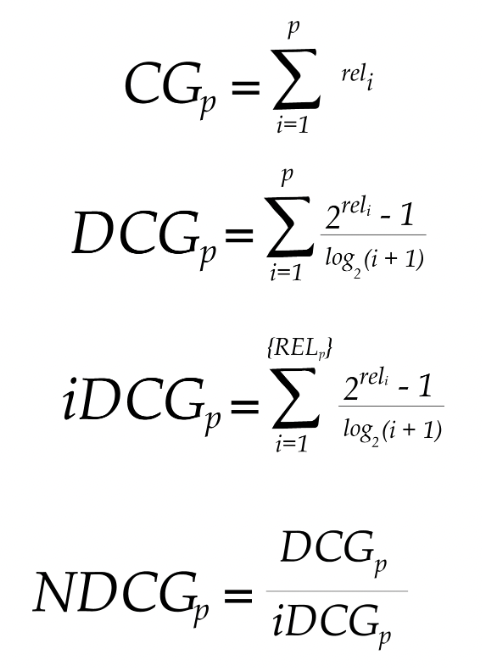
</div>

### O que esperar dessa metrica
O NDCG penaliza quando documentos muito relevantes aparecem numa posicao mais baixa no resultado da search, reduzindo a valor do score de relevancia de acordo com a posicao do resultado (Discounted Cumulative Gain, DCG) e, para comparar esse valor com o de queries com tamanhos diferentes do resultado de busca, o DCG é normalizado pelo tamanho da lista de resultados.

Os valores possivel de NDCG vao de 0 a 1 onde 1 é o valor ideal (documentos relevantes estao aparecendo na ordem que deveriam). Valores baixos de NDCG sao indicativos de que o score de relevancia escolhido pelo meu modelo (BM25) nao é completamente adequado para avaliar a relevancia do produtos - sendo necessario otimizar os hiperparametros do modelo ou incluir outros modelo de score que nao o BM25.

Vale ressaltar que o NDCG sozinho **nao penaliza a presencao de documentos irrelevantes na lista de resultados** e **nao penaliza a falta de documentos relevantes na lista de resultados**. Para uma analise quantitativa mais completa do sistema de search, é necessario usar os resultados das metricas de precisao e recall

***
***

<a id='melhorias'></a>

# 5. Melhorias

O algortimo de search engine desenvolvido aqui é simples - o retriving é feito pelo match palavra-palavra das palavras  da query com as palavras das features de produtos; o ranking é feito com um modelo de bag-of-words (BM25) para calcular o score individual das features de produto e uma funcao linear para combinar esses scores individuais no score de relevancia final.

Algumas etapas que poderiam ser implementadas de forma a melhorar e eficiencia do modelo sao:

**Criacao de Indice:**

* melhorar stem/lemm - ex. lembrancinha = lembrancinhar
* adicionar funcoes para corrigir erros ortograficos
* usar tokenizacao BPE para identificar palavras escritas juntas nas tags - ex. 'jogobanheiro' -> 'jogo' 'banheiro'. 


**Funcao de retrieving:**
* adicionar funcoes para considerar documentos com palavras sinonimos das da query - ex: usar distancia entre palavras como metrica para sinonimos
* adicionar bonus para documentos que dao match exato com a query (todas as palavras da query na mesma ordem)
* Adicionar um "if statement" na condicao de numero minimo de vendas 'ord_min' para nao penalizar demais produtos criados recentemente (e que, portanto terao menos 

**modelo de ranking**
* Otimizar hiperparametros do modelo linear de relevancia **learn to rank**
* testar modelos diferentes (diferentes de funcao linear) para a combinacao de features
    * separar conjunto de dados em conjuntos de teste e treino usar machine learning para prever final_score de relevancia baseado em varias metricas diferentes, por ex.:
        - NDCG, 
        - Clickthrough rate